# **Project: Rainfall–Dengue Relationships Across Climatic Zones (2020–2025)**

## Student: A. Kalpitha Prabhasha Perera (w1985754 / 20222130)
## Supervisor: Mr. Daham Alwis

## **Phase 1:Data Preparation & Cleaning**

In [1]:
# SECTION 1: IMPORT LIBRARIES

import pandas as pd
import numpy as np
from datetime import datetime

print(f"Pandas: {pd.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Execution Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Pandas: 2.2.2
NumPy: 2.0.2
Execution Date: 2026-01-30 09:41:41


In [3]:
# SECTION 2: LOAD RAW DATA

# Paths for environment
rainfall_raw = pd.read_excel('Rainfall_data.xls')
dengue_raw = pd.read_excel('Dengue_Data.xlsx', sheet_name=None)

print(f"Rainfall Raw Shape: {rainfall_raw.shape}")
print(f"Dengue Sheets: {list(dengue_raw.keys())}")

Rainfall Raw Shape: (132, 34)
Dengue Sheets: ['2020', '2021', '2022', '2023', '2024', '2025']


In [4]:
# SECTION 3: RAW DATA QUALITY CHECK - RAINFALL
print(f"Null values:\n{rainfall_raw.isnull().sum()}")
print(f"\nDuplicate rows: {rainfall_raw.duplicated().sum()}")
print(f"Unique stations: {rainfall_raw['station_name'].unique()}")

Null values:
station_name     0
Year             0
Month            0
1                0
2                0
3                0
4                0
5                0
6                0
7                0
8                0
9                0
10               0
11               0
12               0
13               0
14               0
15               0
16               0
17               0
18               0
19               0
20               0
21               0
22               0
23               0
24               0
25               0
26               0
27               0
28               0
29               7
30              11
31              55
dtype: int64

Duplicate rows: 0
Unique stations: ['BALANGODA POST OFFICE' 'UDAWALAWE']


In [5]:
# SECTION 4: CLEAN RAINFALL DATA
# Reshape wide to long
day_cols = [str(i) for i in range(1, 32)]
rainfall_long = rainfall_raw.melt(
    id_vars=['station_name', 'Year', 'Month'],
    value_vars=day_cols,
    var_name='Day',
    value_name='Rainfall_mm'
)
rainfall_long['Day'] = rainfall_long['Day'].astype(int)
print(f"After melt: {rainfall_long.shape}")

# Create date and remove invalid dates
rainfall_long['Date'] = pd.to_datetime(rainfall_long[['Year', 'Month', 'Day']], errors='coerce')
rainfall_long = rainfall_long.dropna(subset=['Date'])
print(f"After removing invalid dates: {rainfall_long.shape}")

# Map station to MOH
station_to_moh = {'BALANGODA POST OFFICE': 'Balangoda', 'UDAWALAWE': 'Udawalawa'}
rainfall_long['MOH'] = rainfall_long['station_name'].map(station_to_moh)

# Calculate ISO week
rainfall_long['ISO_Year'] = rainfall_long['Date'].dt.isocalendar().year.astype(int)
rainfall_long['ISO_Week'] = rainfall_long['Date'].dt.isocalendar().week.astype(int)

# Aggregate to weekly sum
rainfall_weekly = rainfall_long.groupby(['MOH', 'ISO_Year', 'ISO_Week']).agg({
    'Rainfall_mm': 'sum'
}).reset_index()
rainfall_weekly.columns = ['MOH', 'Year', 'Week', 'Rainfall_mm']
print(f"Weekly aggregation: {rainfall_weekly.shape}")

After melt: (4092, 5)
After removing invalid dates: (4019, 6)
Weekly aggregation: (576, 4)


In [6]:
# SECTION 5: VERIFY CLEANED RAINFALL DATA

print(f"Null values: {rainfall_weekly.isnull().sum().sum()}")
print(f"Duplicate rows: {rainfall_weekly.duplicated().sum()}")
print(f"Duplicate keys (MOH+Year+Week): {rainfall_weekly.duplicated(subset=['MOH', 'Year', 'Week']).sum()}")
print(f"Negative values: {(rainfall_weekly['Rainfall_mm'] < 0).sum()}")

Null values: 0
Duplicate rows: 0
Duplicate keys (MOH+Year+Week): 0
Negative values: 0


In [7]:
# SECTION 6: RAW DATA QUALITY CHECK - DENGUE

for year, df in dengue_raw.items():
    print(f"\nYear {year}: Shape={df.shape}, MOH={df['MOH'].unique()}")


Year 2020: Shape=(104, 4), MOH=['Balangoda' 'Udawalawa']

Year 2021: Shape=(104, 4), MOH=['Balangoda' 'Udawalawa']

Year 2022: Shape=(104, 4), MOH=['Balangoda' 'Udawalawa']

Year 2023: Shape=(104, 10), MOH=['Balangoda' 'Udawalawa']

Year 2024: Shape=(104, 4), MOH=['MOH-Balangoda' 'MOH-Udawalwa']

Year 2025: Shape=(104, 14), MOH=['MOH-Balangoda' 'MOH-Udawalwa']


In [8]:
# SECTION 7: CLEAN DENGUE DATA

def clean_dengue_sheet(df, year):
    df_clean = df[['District', 'MOH', 'Week', 'Total']].copy()
    df_clean['MOH'] = df_clean['MOH'].str.replace('MOH-', '', regex=False)
    df_clean['MOH'] = df_clean['MOH'].str.replace('Udawalwa', 'Udawalawa', regex=False)
    df_clean['Year'] = int(year)
    df_clean['District'] = df_clean['District'].str.strip()
    df_clean['MOH'] = df_clean['MOH'].str.strip()
    return df_clean

dengue_cleaned = {}
for year, df in dengue_raw.items():
    dengue_cleaned[year] = clean_dengue_sheet(df, year)
    print(f"Year {year}: Cleaned MOH = {dengue_cleaned[year]['MOH'].unique()}")

dengue_combined = pd.concat(dengue_cleaned.values(), ignore_index=True)
print(f"\nCombined Shape: {dengue_combined.shape}")

Year 2020: Cleaned MOH = ['Balangoda' 'Udawalawa']
Year 2021: Cleaned MOH = ['Balangoda' 'Udawalawa']
Year 2022: Cleaned MOH = ['Balangoda' 'Udawalawa']
Year 2023: Cleaned MOH = ['Balangoda' 'Udawalawa']
Year 2024: Cleaned MOH = ['Balangoda' 'Udawalawa']
Year 2025: Cleaned MOH = ['Balangoda' 'Udawalawa']

Combined Shape: (624, 5)


In [9]:
# SECTION 8: VERIFY CLEANED DENGUE DATA

print(f"Null values: {dengue_combined.isnull().sum().sum()}")
print(f"Duplicate rows: {dengue_combined.duplicated().sum()}")
print(f"Duplicate keys (MOH+Year+Week): {dengue_combined.duplicated(subset=['MOH', 'Year', 'Week']).sum()}")
print(f"Unique MOH: {dengue_combined['MOH'].unique()}")
print(f"Negative values: {(dengue_combined['Total'] < 0).sum()}")

Null values: 20
Duplicate rows: 0
Duplicate keys (MOH+Year+Week): 0
Unique MOH: ['Balangoda' 'Udawalawa']
Negative values: 0


In [10]:
# SECTION 9: MERGE DATASETS

print(f"Dengue shape: {dengue_combined.shape}")
print(f"Rainfall shape: {rainfall_weekly.shape}")

merged_df = dengue_combined.merge(rainfall_weekly, on=['MOH', 'Year', 'Week'], how='left')
print(f"Merged shape: {merged_df.shape}")
print(f"Unmatched rainfall records: {merged_df['Rainfall_mm'].isnull().sum()}")

Dengue shape: (624, 5)
Rainfall shape: (576, 4)
Merged shape: (624, 6)
Unmatched rainfall records: 50


In [11]:
# SECTION 10: FINAL DATASET

final_df = merged_df.rename(columns={'Total': 'Dengue_Cases'})
final_df = final_df[['District', 'MOH', 'Year', 'Week', 'Dengue_Cases', 'Rainfall_mm']]

print(f"Shape: {final_df.shape}")
print(f"Columns: {list(final_df.columns)}")
print(f"\nData Types:\n{final_df.dtypes}")
print(f"\nNull values:\n{final_df.isnull().sum()}")
print(f"\nDuplicate rows: {final_df.duplicated().sum()}")
print(f"Duplicate keys: {final_df.duplicated(subset=['MOH', 'Year', 'Week']).sum()}")
print(f"\nDescriptive Statistics:\n{final_df.describe()}")
print(f"\nRecords per MOH:\n{final_df.groupby('MOH').size()}")
print(f"\nRecords per Year:\n{final_df.groupby('Year').size()}")
print(f"\nFirst 10 rows:\n{final_df.head(10)}")

Shape: (624, 6)
Columns: ['District', 'MOH', 'Year', 'Week', 'Dengue_Cases', 'Rainfall_mm']

Data Types:
District         object
MOH              object
Year              int64
Week              int64
Dengue_Cases    float64
Rainfall_mm     float64
dtype: object

Null values:
District         0
MOH              0
Year             0
Week             0
Dengue_Cases    20
Rainfall_mm     50
dtype: int64

Duplicate rows: 0
Duplicate keys: 0

Descriptive Statistics:
              Year        Week  Dengue_Cases  Rainfall_mm
count   624.000000  624.000000    604.000000   574.000000
mean   2022.500000   26.500000      2.052980    37.502962
std       1.709195   15.020371      3.387203    46.255138
min    2020.000000    1.000000      0.000000     0.000000
25%    2021.000000   13.750000      0.000000     2.925000
50%    2022.500000   26.500000      1.000000    20.200000
75%    2024.000000   39.250000      2.000000    53.275000
max    2025.000000   52.000000     28.000000   239.200000

Records per

In [12]:
# SECTION 11: SAVE DATA

final_df.to_csv('cleaned_dengue_rainfall_data.csv', index=False)
final_df.to_excel('cleaned_dengue_rainfall_data.xlsx', index=False)
print(" Saved: cleaned_dengue_rainfall_data.csv")
print(" Saved: cleaned_dengue_rainfall_data.xlsx")

# Verify
verify_df = pd.read_csv('cleaned_dengue_rainfall_data.csv')
print(f"\nVerify - Loaded shape: {verify_df.shape}")
print(f"Verify - Original shape: {final_df.shape}")
if verify_df.shape == final_df.shape:
    print(" CONFIRMED: File saved correctly")


 Saved: cleaned_dengue_rainfall_data.csv
 Saved: cleaned_dengue_rainfall_data.xlsx

Verify - Loaded shape: (624, 6)
Verify - Original shape: (624, 6)
 CONFIRMED: File saved correctly


# **Phase 2: Exploratory Data Analysis (EDA)**

In [ ]:
# SECTION 1: IMPORT ADDITIONAL LIBRARIES

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# SECTION 2: LOAD CLEANED DATA

df = pd.read_csv('cleaned_dengue_rainfall_data.csv')
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

Shape: (624, 6)
Columns: ['District', 'MOH', 'Year', 'Week', 'Dengue_Cases', 'Rainfall_mm']


In [ ]:
# SECTION 3: DESCRIPTIVE STATISTICS

print("\n--- Overall Statistics ---")
print(df[['Dengue_Cases', 'Rainfall_mm']].describe())

print("\n--- Statistics by MOH Area ---")
for moh in df['MOH'].unique():
    print(f"\n{moh}:")
    print(df[df['MOH'] == moh][['Dengue_Cases', 'Rainfall_mm']].describe())


--- Overall Statistics ---
       Dengue_Cases  Rainfall_mm
count    604.000000   574.000000
mean       2.052980    37.502962
std        3.387203    46.255138
min        0.000000     0.000000
25%        0.000000     2.925000
50%        1.000000    20.200000
75%        2.000000    53.275000
max       28.000000   239.200000

--- Statistics by MOH Area ---

Balangoda:
       Dengue_Cases  Rainfall_mm
count    302.000000   283.000000
mean       3.046358    46.162191
std        4.272041    52.389236
min        0.000000     0.000000
25%        0.000000     5.850000
50%        1.500000    28.600000
75%        4.000000    63.700000
max       28.000000   238.600000

Udawalawa:
       Dengue_Cases  Rainfall_mm
count    302.000000   291.000000
mean       1.059603    29.081787
std        1.659491    37.605592
min        0.000000     0.000000
25%        0.000000     1.350000
50%        0.000000    12.700000
75%        2.000000    41.500000
max       14.000000   239.200000


In [ ]:
# SECTION 4: CREATE DATE COLUMN

df['Week_Start'] = pd.to_datetime(df['Year'].astype(str) + df['Week'].astype(str) + '1', format='%Y%W%w')
df = df.sort_values(['MOH', 'Week_Start']).reset_index(drop=True)
print(f"Date range: {df['Week_Start'].min()} to {df['Week_Start'].max()}")


Date range: 2020-01-06 00:00:00 to 2025-12-29 00:00:00


SECTION 5: TIME SERIES PLOTS


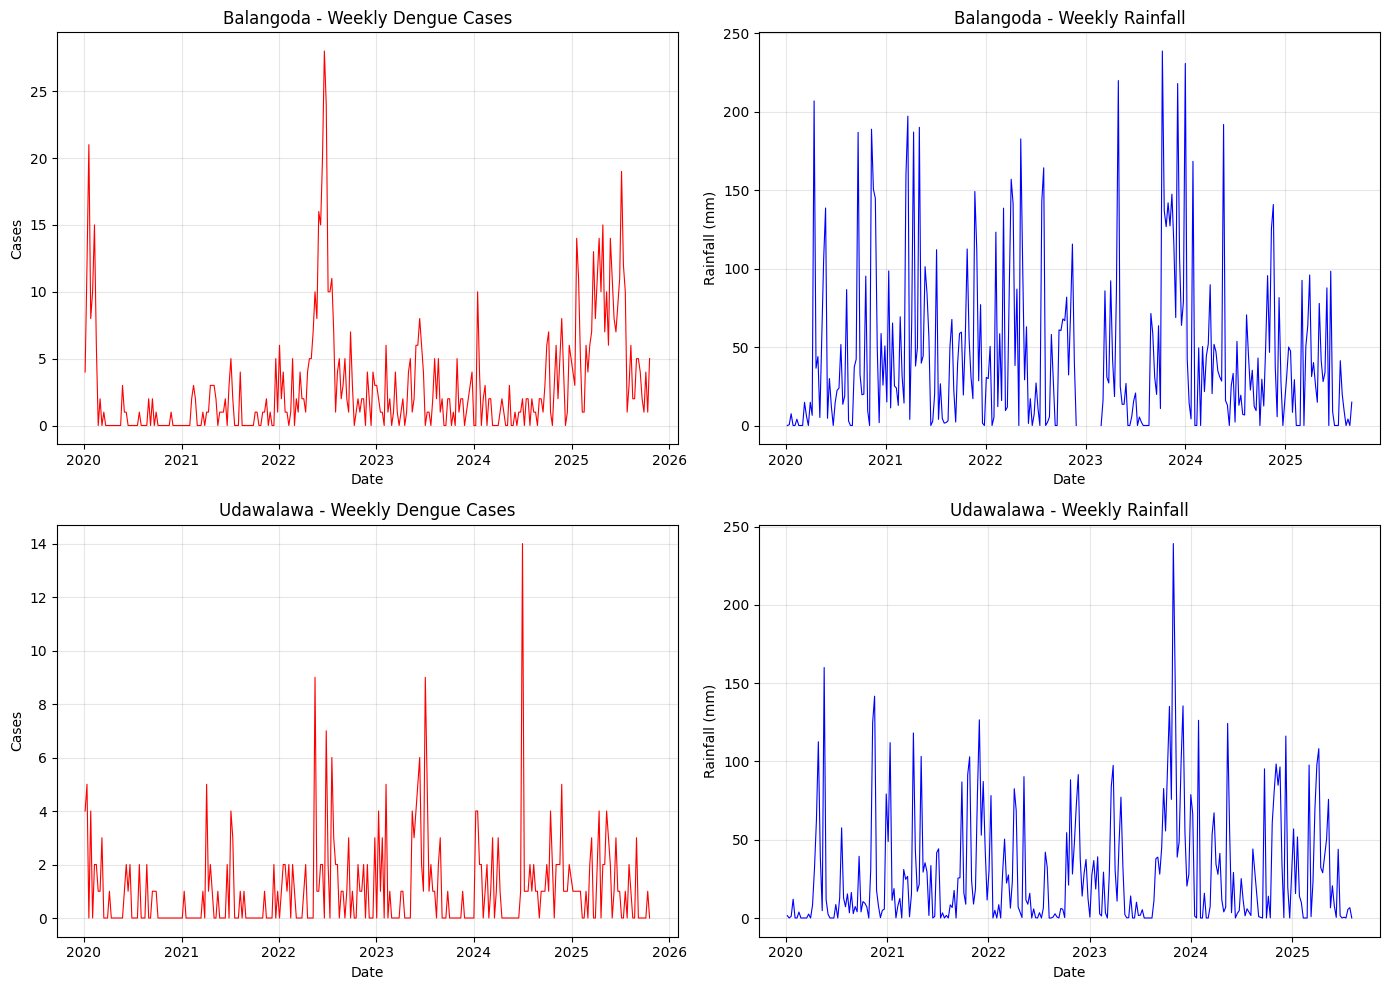

✓ Saved: 01_time_series_plots.png


In [ ]:
# SECTION 5: TIME SERIES PLOTS

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, moh in enumerate(df['MOH'].unique()):
    moh_data = df[df['MOH'] == moh]

    axes[idx, 0].plot(moh_data['Week_Start'], moh_data['Dengue_Cases'], color='red', linewidth=0.8)
    axes[idx, 0].set_title(f'{moh} - Weekly Dengue Cases')
    axes[idx, 0].set_xlabel('Date')
    axes[idx, 0].set_ylabel('Cases')
    axes[idx, 0].grid(True, alpha=0.3)

    axes[idx, 1].plot(moh_data['Week_Start'], moh_data['Rainfall_mm'], color='blue', linewidth=0.8)
    axes[idx, 1].set_title(f'{moh} - Weekly Rainfall')
    axes[idx, 1].set_xlabel('Date')
    axes[idx, 1].set_ylabel('Rainfall (mm)')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('01_time_series_plots.png', dpi=150)
plt.show()

SECTION 6: OVERLAY PLOT


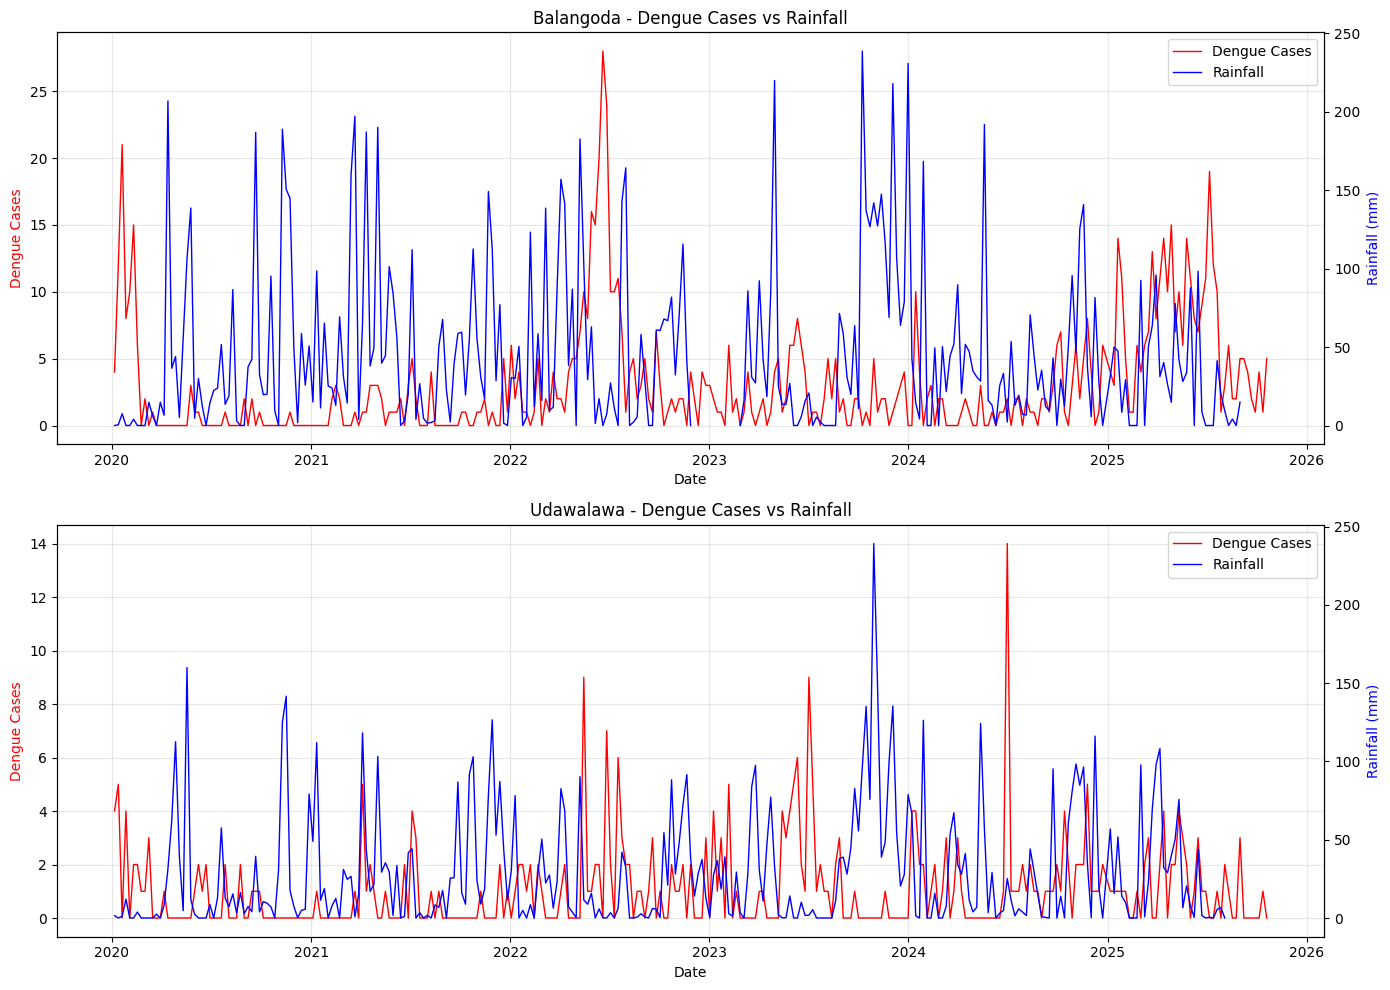

✓ Saved: 02_overlay_plots.png


In [ ]:
# SECTION 6: OVERLAY PLOT (DENGUE vs RAINFALL)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

for idx, moh in enumerate(df['MOH'].unique()):
    moh_data = df[df['MOH'] == moh]

    ax1 = axes[idx]
    ax2 = ax1.twinx()

    line1 = ax1.plot(moh_data['Week_Start'], moh_data['Dengue_Cases'], color='red', linewidth=1, label='Dengue Cases')
    line2 = ax2.plot(moh_data['Week_Start'], moh_data['Rainfall_mm'], color='blue', linewidth=1, label='Rainfall')

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Dengue Cases', color='red')
    ax2.set_ylabel('Rainfall (mm)', color='blue')
    ax1.set_title(f'{moh} - Dengue Cases vs Rainfall')
    ax1.grid(True, alpha=0.3)

    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.savefig('02_overlay_plots.png', dpi=150)
plt.show()

SECTION 7: SEASONAL PATTERN


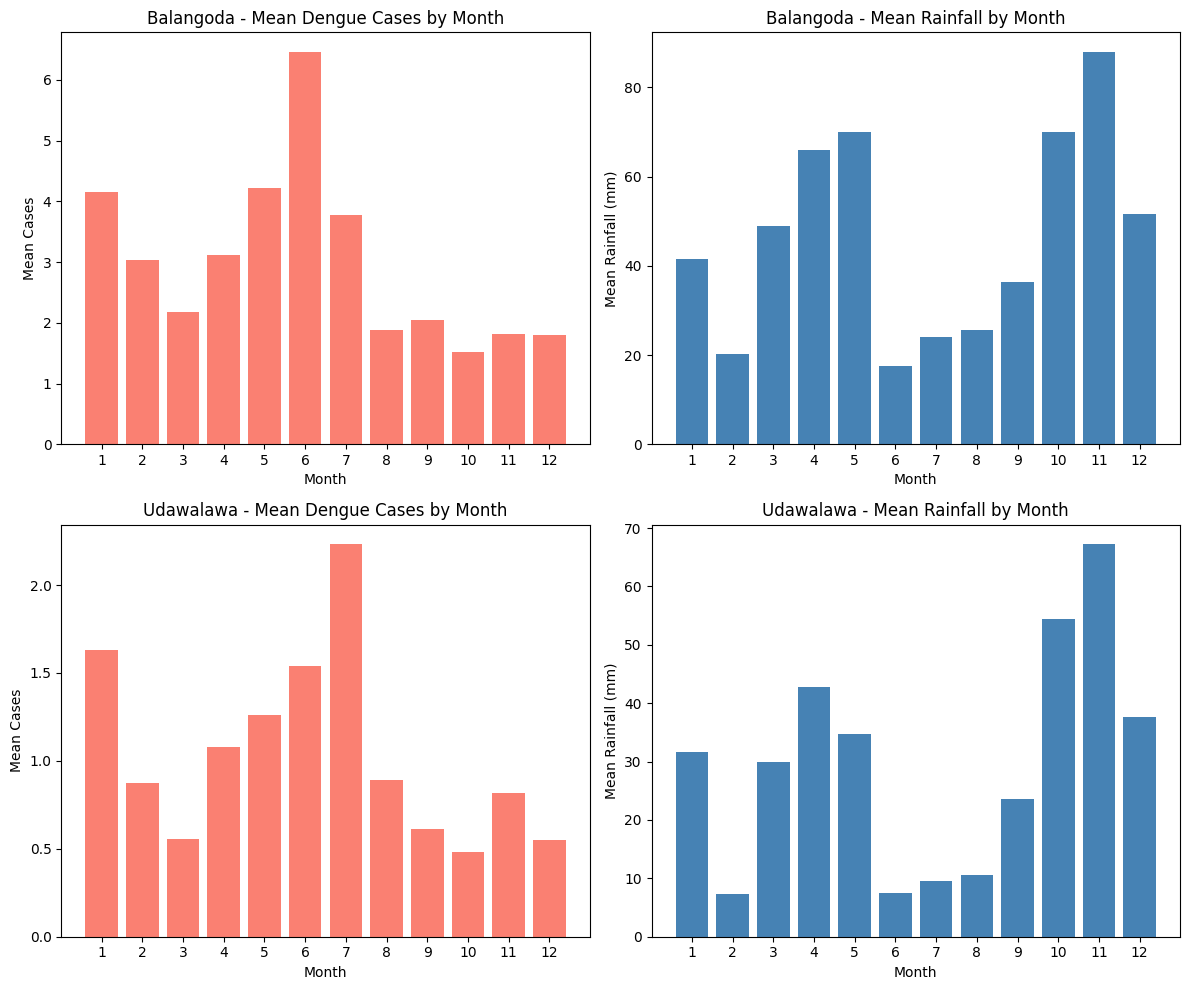

✓ Saved: 03_seasonal_patterns.png

--- Monthly Average Dengue Cases ---
MOH    Balangoda  Udawalawa
Month                      
1           4.15       1.63
2           3.04       0.88
3           2.19       0.56
4           3.12       1.08
5           4.22       1.26
6           6.46       1.54
7           3.77       2.23
8           1.89       0.89
9           2.04       0.62
10          1.52       0.48
11          1.82       0.82
12          1.80       0.55

--- Monthly Average Rainfall (mm) ---
MOH    Balangoda  Udawalawa
Month                      
1          41.43      31.58
2          20.17       7.27
3          48.86      29.87
4          66.01      42.81
5          69.94      34.66
6          17.44       7.51
7          24.00       9.62
8          25.63      10.60
9          36.29      23.63
10         70.12      54.39
11         87.96      67.20
12         51.61      37.61


In [ ]:
# SECTION 7: SEASONAL PATTERN - MONTHLY AVERAGES

print("SECTION 7: SEASONAL PATTERN")

df['Month'] = df['Week_Start'].dt.month

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for idx, moh in enumerate(df['MOH'].unique()):
    moh_data = df[df['MOH'] == moh]

    monthly_dengue = moh_data.groupby('Month')['Dengue_Cases'].mean()
    monthly_rain = moh_data.groupby('Month')['Rainfall_mm'].mean()

    axes[idx, 0].bar(monthly_dengue.index, monthly_dengue.values, color='salmon')
    axes[idx, 0].set_title(f'{moh} - Mean Dengue Cases by Month')
    axes[idx, 0].set_xlabel('Month')
    axes[idx, 0].set_ylabel('Mean Cases')
    axes[idx, 0].set_xticks(range(1, 13))

    axes[idx, 1].bar(monthly_rain.index, monthly_rain.values, color='steelblue')
    axes[idx, 1].set_title(f'{moh} - Mean Rainfall by Month')
    axes[idx, 1].set_xlabel('Month')
    axes[idx, 1].set_ylabel('Mean Rainfall (mm)')
    axes[idx, 1].set_xticks(range(1, 13))

plt.tight_layout()
plt.savefig('03_seasonal_patterns.png', dpi=150)
plt.show()
print("✓ Saved: 03_seasonal_patterns.png")

print("\n--- Monthly Average Dengue Cases ---")
print(df.pivot_table(values='Dengue_Cases', index='Month', columns='MOH', aggfunc='mean').round(2))

print("\n--- Monthly Average Rainfall (mm) ---")
print(df.pivot_table(values='Rainfall_mm', index='Month', columns='MOH', aggfunc='mean').round(2))

SECTION 8: YEARLY TRENDS


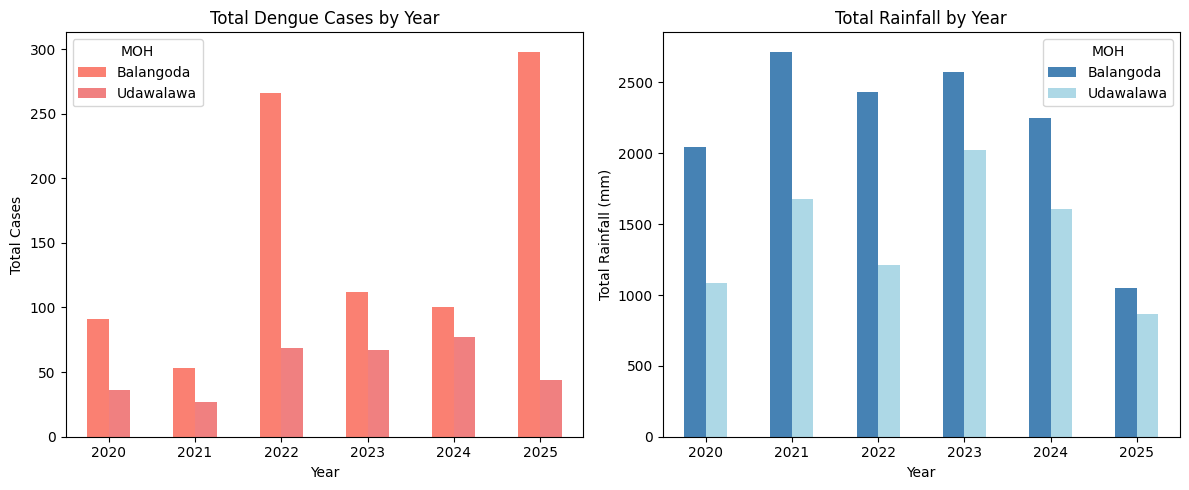

✓ Saved: 04_yearly_trends.png

--- Yearly Total Dengue Cases ---
MOH   Balangoda  Udawalawa
Year                      
2020       91.0       36.0
2021       53.0       27.0
2022      266.0       69.0
2023      112.0       67.0
2024      100.0       77.0
2025      298.0       44.0

--- Yearly Total Rainfall (mm) ---
MOH   Balangoda  Udawalawa
Year                      
2020     2041.4     1084.9
2021     2717.8     1676.3
2022     2434.7     1210.0
2023     2571.0     2020.6
2024     2252.2     1605.3
2025     1046.8      865.7


In [ ]:
# SECTION 8: YEARLY TRENDS

print("SECTION 8: YEARLY TRENDS")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

yearly_dengue = df.groupby(['Year', 'MOH'])['Dengue_Cases'].sum().unstack()
yearly_dengue.plot(kind='bar', ax=axes[0], color=['salmon', 'lightcoral'])
axes[0].set_title('Total Dengue Cases by Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Total Cases')
axes[0].tick_params(axis='x', rotation=0)

yearly_rain = df.groupby(['Year', 'MOH'])['Rainfall_mm'].sum().unstack()
yearly_rain.plot(kind='bar', ax=axes[1], color=['steelblue', 'lightblue'])
axes[1].set_title('Total Rainfall by Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Total Rainfall (mm)')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('04_yearly_trends.png', dpi=150)
plt.show()
print("✓ Saved: 04_yearly_trends.png")

print("\n--- Yearly Total Dengue Cases ---")
print(yearly_dengue)

print("\n--- Yearly Total Rainfall (mm) ---")
print(yearly_rain.round(2))

SECTION 9: DISTRIBUTION ANALYSIS


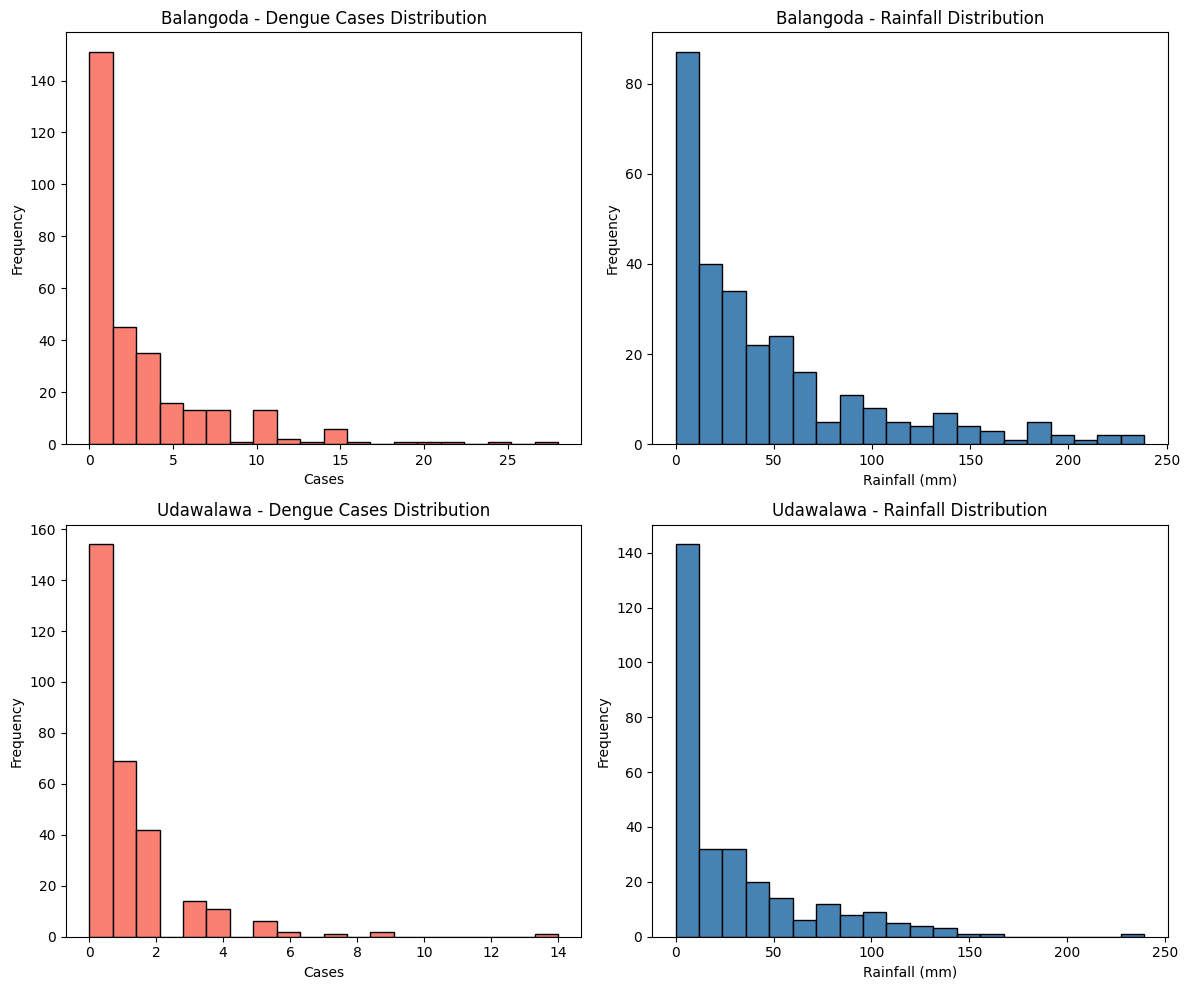

✓ Saved: 05_distributions.png


In [ ]:
# SECTION 9: DISTRIBUTION ANALYSIS

print("SECTION 9: DISTRIBUTION ANALYSIS")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for idx, moh in enumerate(df['MOH'].unique()):
    moh_data = df[df['MOH'] == moh]

    axes[idx, 0].hist(moh_data['Dengue_Cases'], bins=20, color='salmon', edgecolor='black')
    axes[idx, 0].set_title(f'{moh} - Dengue Cases Distribution')
    axes[idx, 0].set_xlabel('Cases')
    axes[idx, 0].set_ylabel('Frequency')

    axes[idx, 1].hist(moh_data['Rainfall_mm'].dropna(), bins=20, color='steelblue', edgecolor='black')
    axes[idx, 1].set_title(f'{moh} - Rainfall Distribution')
    axes[idx, 1].set_xlabel('Rainfall (mm)')
    axes[idx, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('05_distributions.png', dpi=150)
plt.show()
print("✓ Saved: 05_distributions.png")

SECTION 10: BOXPLOTS


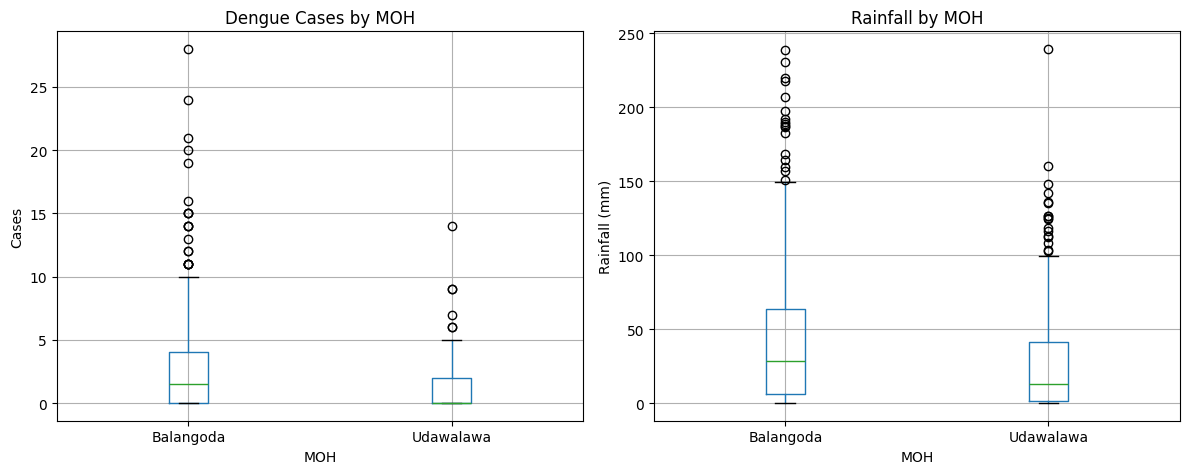

✓ Saved: 06_boxplots.png


In [ ]:
# SECTION 10: BOXPLOTS

print("SECTION 10: BOXPLOTS")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df.boxplot(column='Dengue_Cases', by='MOH', ax=axes[0])
axes[0].set_title('Dengue Cases by MOH')
axes[0].set_xlabel('MOH')
axes[0].set_ylabel('Cases')

df.boxplot(column='Rainfall_mm', by='MOH', ax=axes[1])
axes[1].set_title('Rainfall by MOH')
axes[1].set_xlabel('MOH')
axes[1].set_ylabel('Rainfall (mm)')

plt.suptitle('')
plt.tight_layout()
plt.savefig('06_boxplots.png', dpi=150)
plt.show()
print("✓ Saved: 06_boxplots.png")

SECTION 11: CORRELATION ANALYSIS

--- Pearson Correlation (Dengue vs Rainfall) ---
Balangoda: r = -0.1613
Udawalawa: r = -0.1150


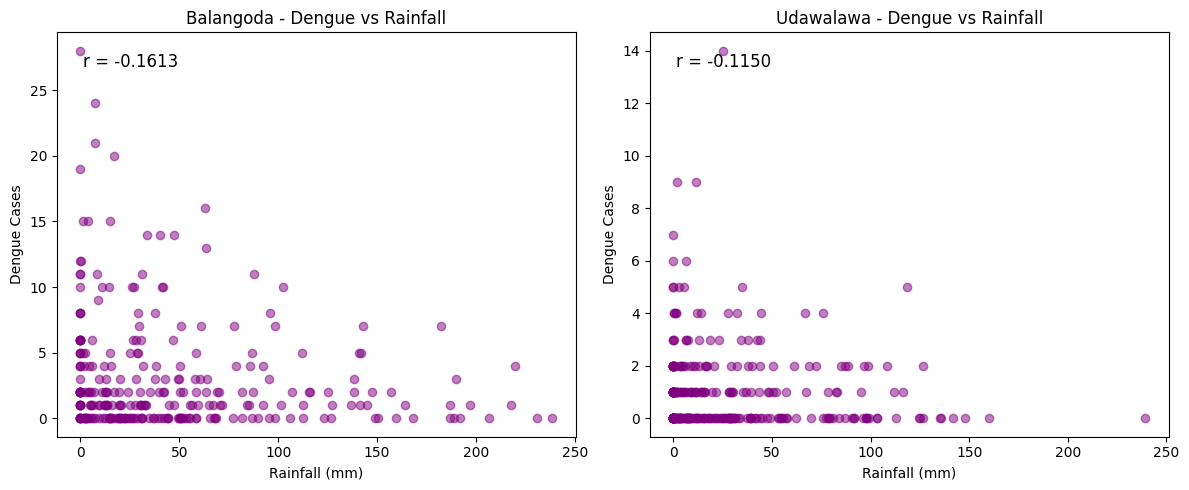

✓ Saved: 07_scatter_correlation.png


In [ ]:
# SECTION 11: CORRELATION ANALYSIS

print("SECTION 11: CORRELATION ANALYSIS")

print("\n--- Pearson Correlation (Dengue vs Rainfall) ---")
for moh in df['MOH'].unique():
    moh_data = df[df['MOH'] == moh].dropna()
    corr = moh_data['Dengue_Cases'].corr(moh_data['Rainfall_mm'])
    print(f"{moh}: r = {corr:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, moh in enumerate(df['MOH'].unique()):
    moh_data = df[df['MOH'] == moh].dropna()
    axes[idx].scatter(moh_data['Rainfall_mm'], moh_data['Dengue_Cases'], alpha=0.5, color='purple')
    axes[idx].set_title(f'{moh} - Dengue vs Rainfall')
    axes[idx].set_xlabel('Rainfall (mm)')
    axes[idx].set_ylabel('Dengue Cases')
    corr = moh_data['Dengue_Cases'].corr(moh_data['Rainfall_mm'])
    axes[idx].text(0.05, 0.95, f'r = {corr:.4f}', transform=axes[idx].transAxes, fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.savefig('07_scatter_correlation.png', dpi=150)
plt.show()
print("✓ Saved: 07_scatter_correlation.png")


SECTION 12: HEATMAP


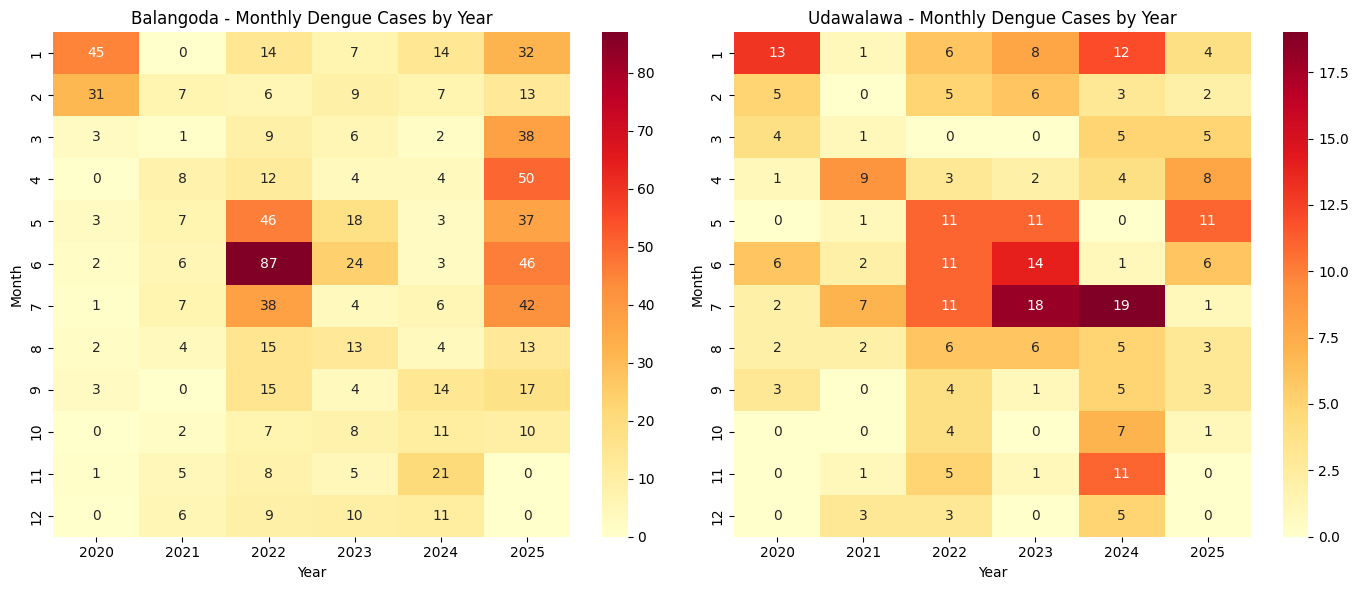

✓ Saved: 08_heatmap_dengue.png


In [ ]:
# SECTION 12: HEATMAP - MONTHLY DENGUE BY YEAR

print("SECTION 12: HEATMAP")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, moh in enumerate(df['MOH'].unique()):
    moh_data = df[df['MOH'] == moh]
    pivot = moh_data.pivot_table(values='Dengue_Cases', index='Month', columns='Year', aggfunc='sum')
    sns.heatmap(pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[idx])
    axes[idx].set_title(f'{moh} - Monthly Dengue Cases by Year')
    axes[idx].set_xlabel('Year')
    axes[idx].set_ylabel('Month')

plt.tight_layout()
plt.savefig('08_heatmap_dengue.png', dpi=150)
plt.show()
print("✓ Saved: 08_heatmap_dengue.png")


In [ ]:
# SECTION 13: MOH COMPARISON

print("SECTION 13: MOH COMPARISON")

comparison = df.groupby('MOH').agg({
    'Dengue_Cases': ['sum', 'mean', 'std', 'max'],
    'Rainfall_mm': ['sum', 'mean', 'std', 'max']
}).round(2)
print(comparison)

SECTION 13: MOH COMPARISON
          Dengue_Cases                   Rainfall_mm                     
                   sum  mean   std   max         sum   mean    std    max
MOH                                                                      
Balangoda        920.0  3.05  4.27  28.0     13063.9  46.16  52.39  238.6
Udawalawa        320.0  1.06  1.66  14.0      8462.8  29.08  37.61  239.2


In [ ]:
# SECTION 14: OUTLIER DETECTION

print("SECTION 14: OUTLIER DETECTION")

for moh in df['MOH'].unique():
    print(f"\n{moh}:")
    moh_data = df[df['MOH'] == moh]

    for col in ['Dengue_Cases', 'Rainfall_mm']:
        Q1 = moh_data[col].quantile(0.25)
        Q3 = moh_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = moh_data[(moh_data[col] < lower) | (moh_data[col] > upper)]
        print(f"  {col}: {len(outliers)} outliers")


SECTION 14: OUTLIER DETECTION

Balangoda:
  Dengue_Cases: 20 outliers
  Rainfall_mm: 17 outliers

Udawalawa:
  Dengue_Cases: 6 outliers
  Rainfall_mm: 17 outliers


### **PHASE 3: STATIONARITY TESTING & CROSS-CORRELATION ANALYSIS**

In [ ]:
# SECTION 1: IMPORT ADDITIONAL LIBRARIES

from statsmodels.tsa.stattools import adfuller, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# SECTION 2: PREPARE TIME SERIES DATA

# Ensure data is sorted by date
df = df.sort_values(['MOH', 'Week_Start']).reset_index(drop=True)

# Create separate dataframes for each MOH
balangoda_df = df[df['MOH'] == 'Balangoda'].copy().reset_index(drop=True)
udawalawa_df = df[df['MOH'] == 'Udawalawa'].copy().reset_index(drop=True)

print(f"Balangoda records: {len(balangoda_df)}")
print(f"Udawalawa records: {len(udawalawa_df)}")


Balangoda records: 312
Udawalawa records: 312


In [ ]:
# SECTION 3: ADF STATIONARITY TEST - FUNCTION

def adf_test(series, name):
    """
    Perform Augmented Dickey-Fuller test for stationarity

    Null Hypothesis (H0): Series has a unit root (non-stationary)
    Alternative (H1): Series is stationary

    If p-value < 0.05: Reject H0 → Series is STATIONARY
    If p-value >= 0.05: Fail to reject H0 → Series is NON-STATIONARY
    """
    # Remove NaN values
    clean_series = series.dropna()

    result = adfuller(clean_series, autolag='AIC')

    print(f"\n--- ADF Test: {name} ---")
    print(f"Test Statistic: {result[0]:.4f}")
    print(f"P-Value: {result[1]:.4f}")
    print(f"Lags Used: {result[2]}")
    print(f"Observations: {result[3]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.4f}")

    if result[1] < 0.05:
        print(f"Result: STATIONARY (p < 0.05) ✓")
        return True
    else:
        print(f"Result: NON-STATIONARY (p >= 0.05) ✗")
        return False


In [ ]:
# SECTION 4: ADF TEST - BALANGODA

bal_dengue_stationary = adf_test(balangoda_df['Dengue_Cases'], 'Balangoda - Dengue Cases')
bal_rain_stationary = adf_test(balangoda_df['Rainfall_mm'], 'Balangoda - Rainfall')



--- ADF Test: Balangoda - Dengue Cases ---
Test Statistic: -4.2365
P-Value: 0.0006
Lags Used: 3
Observations: 298
Critical Values:
  1%: -3.4525
  5%: -2.8713
  10%: -2.5720
Result: STATIONARY (p < 0.05) ✓

--- ADF Test: Balangoda - Rainfall ---
Test Statistic: -5.5691
P-Value: 0.0000
Lags Used: 3
Observations: 279
Critical Values:
  1%: -3.4540
  5%: -2.8720
  10%: -2.5723
Result: STATIONARY (p < 0.05) ✓


In [ ]:
# SECTION 5: ADF TEST - UDAWALAWA

uda_dengue_stationary = adf_test(udawalawa_df['Dengue_Cases'], 'Udawalawa - Dengue Cases')
uda_rain_stationary = adf_test(udawalawa_df['Rainfall_mm'], 'Udawalawa - Rainfall')


--- ADF Test: Udawalawa - Dengue Cases ---
Test Statistic: -4.8728
P-Value: 0.0000
Lags Used: 5
Observations: 296
Critical Values:
  1%: -3.4526
  5%: -2.8714
  10%: -2.5720
Result: STATIONARY (p < 0.05) ✓

--- ADF Test: Udawalawa - Rainfall ---
Test Statistic: -5.6379
P-Value: 0.0000
Lags Used: 3
Observations: 287
Critical Values:
  1%: -3.4533
  5%: -2.8717
  10%: -2.5722
Result: STATIONARY (p < 0.05) ✓


In [ ]:
# SECTION 6: STATIONARITY SUMMARY

print("\n--- Summary Table ---")
print(f"{'Variable':<30} {'Stationary?':<15}")
print("-" * 45)
print(f"{'Balangoda - Dengue Cases':<30} {'Yes ✓' if bal_dengue_stationary else 'No ✗':<15}")
print(f"{'Balangoda - Rainfall':<30} {'Yes ✓' if bal_rain_stationary else 'No ✗':<15}")
print(f"{'Udawalawa - Dengue Cases':<30} {'Yes ✓' if uda_dengue_stationary else 'No ✗':<15}")
print(f"{'Udawalawa - Rainfall':<30} {'Yes ✓' if uda_rain_stationary else 'No ✗':<15}")



--- Summary Table ---
Variable                       Stationary?    
---------------------------------------------
Balangoda - Dengue Cases       Yes ✓          
Balangoda - Rainfall           Yes ✓          
Udawalawa - Dengue Cases       Yes ✓          
Udawalawa - Rainfall           Yes ✓          


In [ ]:
# SECTION 7: DIFFERENCING

# Apply differencing if non-stationary
if not bal_dengue_stationary:
    balangoda_df['Dengue_Diff'] = balangoda_df['Dengue_Cases'].diff()
    print("\nBalangoda Dengue - Applied 1st order differencing")
    adf_test(balangoda_df['Dengue_Diff'].dropna(), 'Balangoda - Dengue (Differenced)')

if not uda_dengue_stationary:
    udawalawa_df['Dengue_Diff'] = udawalawa_df['Dengue_Cases'].diff()
    print("\nUdawalawa Dengue - Applied 1st order differencing")
    adf_test(udawalawa_df['Dengue_Diff'].dropna(), 'Udawalawa - Dengue (Differenced)')

print("\nNote: If still non-stationary, d=1 will be used in SARIMAX model")



Note: If still non-stationary, d=1 will be used in SARIMAX model


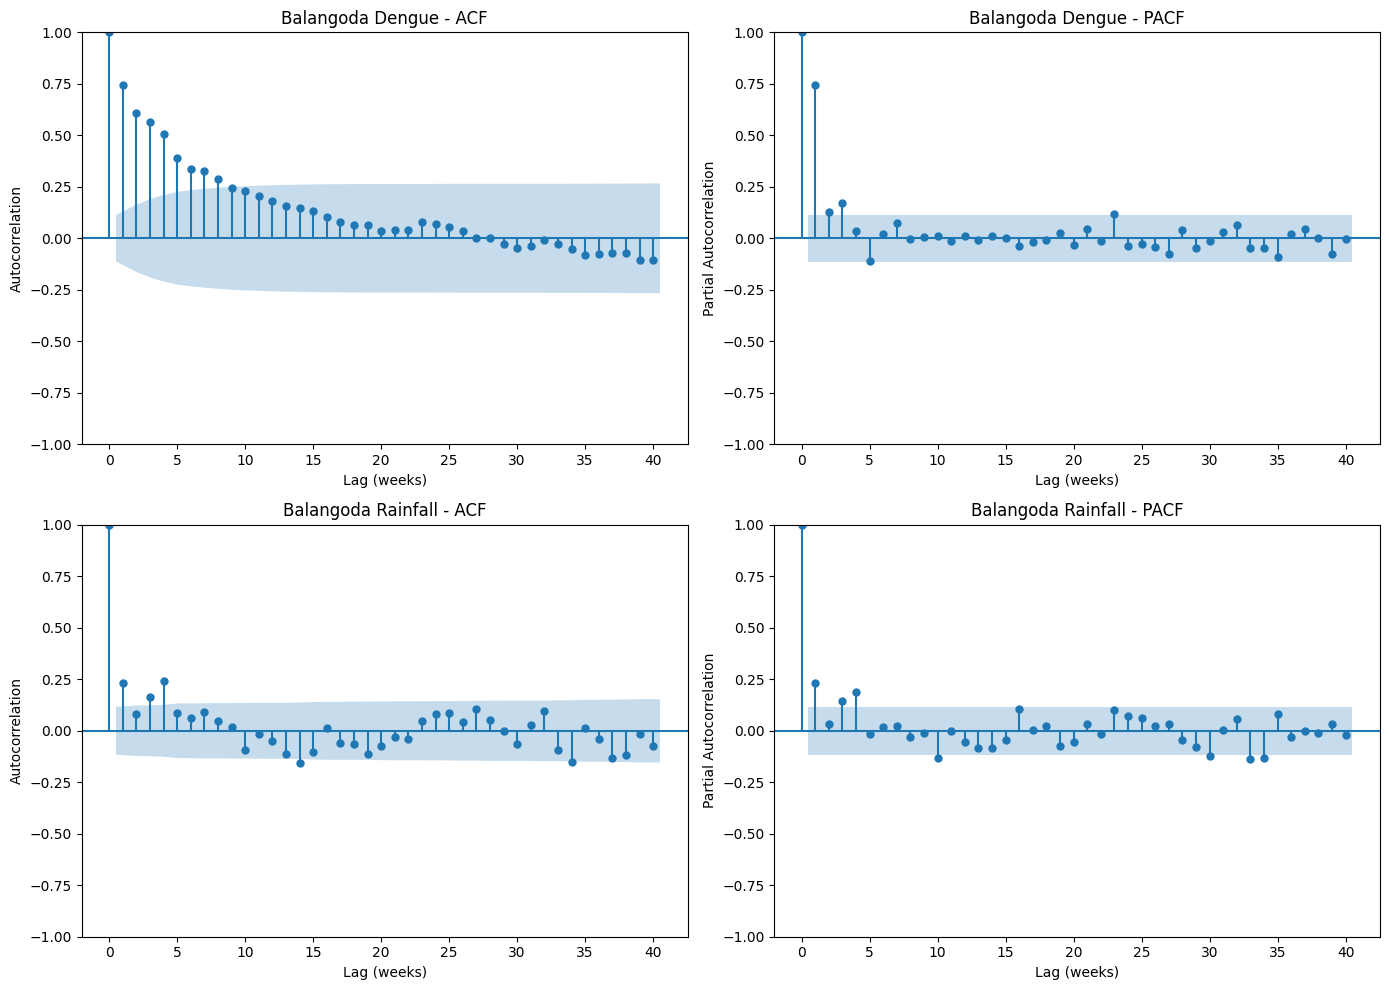

In [ ]:
# SECTION 8: ACF PLOT - BALANGODA
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Dengue ACF/PACF
plot_acf(balangoda_df['Dengue_Cases'].dropna(), ax=axes[0, 0], lags=40, title='Balangoda Dengue - ACF')
axes[0, 0].set_xlabel('Lag (weeks)')
axes[0, 0].set_ylabel('Autocorrelation')

plot_pacf(balangoda_df['Dengue_Cases'].dropna(), ax=axes[0, 1], lags=40, title='Balangoda Dengue - PACF')
axes[0, 1].set_xlabel('Lag (weeks)')
axes[0, 1].set_ylabel('Partial Autocorrelation')

# Rainfall ACF/PACF
plot_acf(balangoda_df['Rainfall_mm'].dropna(), ax=axes[1, 0], lags=40, title='Balangoda Rainfall - ACF')
axes[1, 0].set_xlabel('Lag (weeks)')
axes[1, 0].set_ylabel('Autocorrelation')

plot_pacf(balangoda_df['Rainfall_mm'].dropna(), ax=axes[1, 1], lags=40, title='Balangoda Rainfall - PACF')
axes[1, 1].set_xlabel('Lag (weeks)')
axes[1, 1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.savefig('09_acf_pacf_balangoda.png', dpi=150)
plt.show()


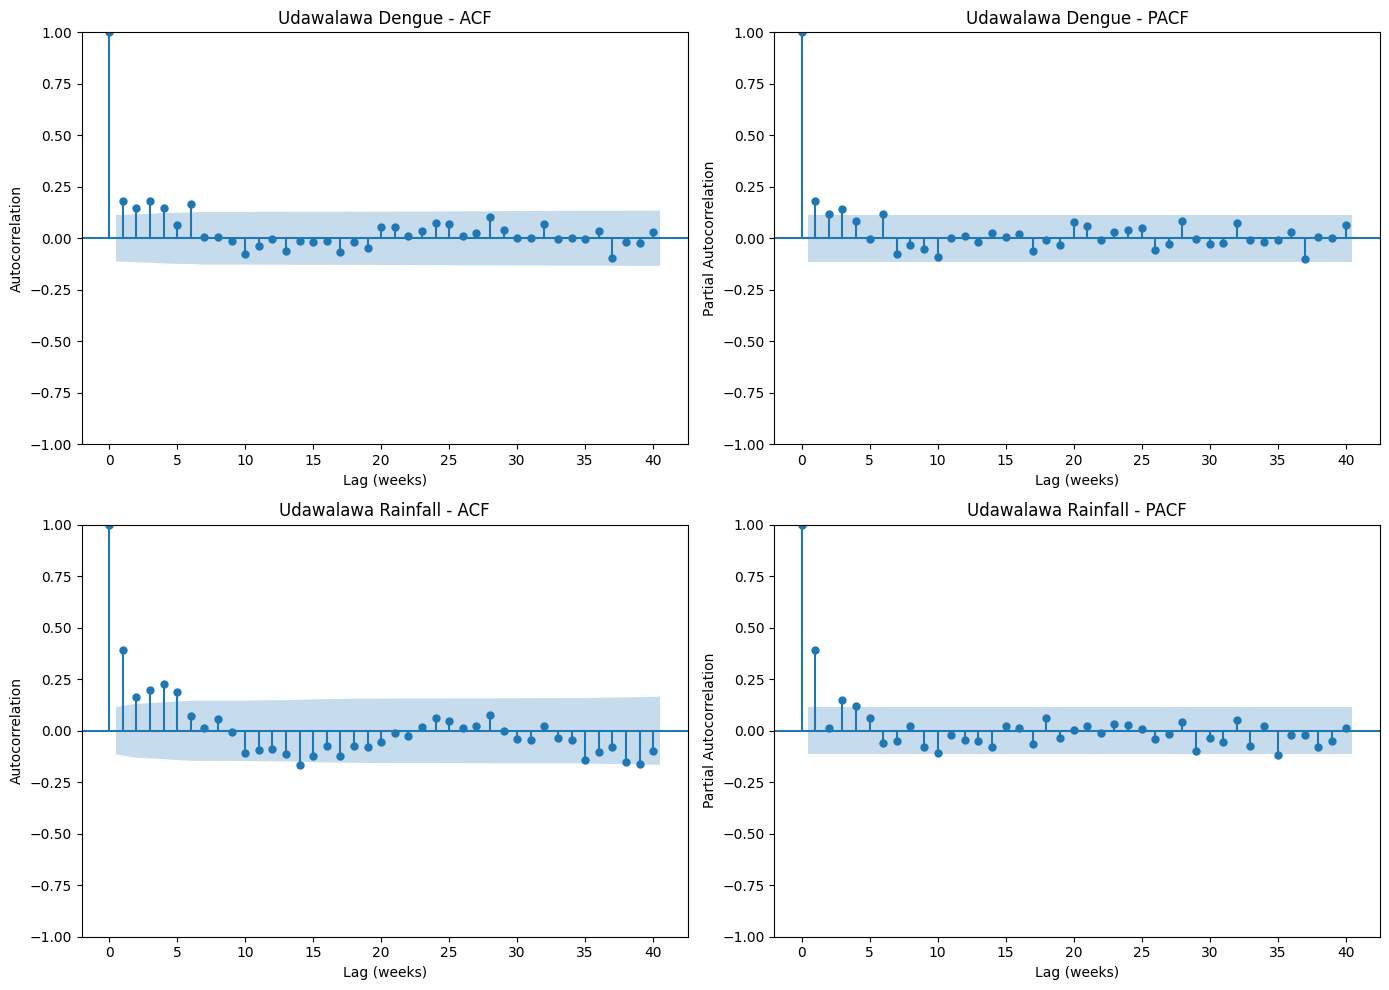

✓ Saved: 10_acf_pacf_udawalawa.png


In [ ]:
# SECTION 9: ACF/PACF PLOTS - UDAWALAWA

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Dengue ACF
plot_acf(udawalawa_df['Dengue_Cases'].dropna(), ax=axes[0, 0], lags=40, title='Udawalawa Dengue - ACF')
axes[0, 0].set_xlabel('Lag (weeks)')
axes[0, 0].set_ylabel('Autocorrelation')

# Dengue PACF
plot_pacf(udawalawa_df['Dengue_Cases'].dropna(), ax=axes[0, 1], lags=40, title='Udawalawa Dengue - PACF')
axes[0, 1].set_xlabel('Lag (weeks)')
axes[0, 1].set_ylabel('Partial Autocorrelation')

# Rainfall ACF
plot_acf(udawalawa_df['Rainfall_mm'].dropna(), ax=axes[1, 0], lags=40, title='Udawalawa Rainfall - ACF')
axes[1, 0].set_xlabel('Lag (weeks)')
axes[1, 0].set_ylabel('Autocorrelation')

# Rainfall PACF
plot_pacf(udawalawa_df['Rainfall_mm'].dropna(), ax=axes[1, 1], lags=40, title='Udawalawa Rainfall - PACF')
axes[1, 1].set_xlabel('Lag (weeks)')
axes[1, 1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.savefig('10_acf_pacf_udawalawa.png', dpi=150)
plt.show()
print("✓ Saved: 10_acf_pacf_udawalawa.png")



Cross-Correlation Values (Lag 0-20 weeks):
----------------------------------------
Lag  0: r = -0.1613
Lag  1: r = -0.1353
Lag  2: r = -0.1214
Lag  3: r = -0.1508
Lag  4: r = -0.1976
Lag  5: r = -0.1061
Lag  6: r = -0.1170
Lag  7: r = -0.1007
Lag  8: r = -0.1518
Lag  9: r = -0.0864
Lag 10: r = -0.0889
Lag 11: r = -0.1147
Lag 12: r = -0.0930
Lag 13: r = -0.0872
Lag 14: r = -0.0689
Lag 15: r = -0.0530
Lag 16: r = -0.0389
Lag 17: r = 0.0127
Lag 18: r = 0.0450 ← OPTIMAL
Lag 19: r = -0.0171
Lag 20: r = -0.0390

*** OPTIMAL LAG: 18 weeks (r = 0.0450) ***


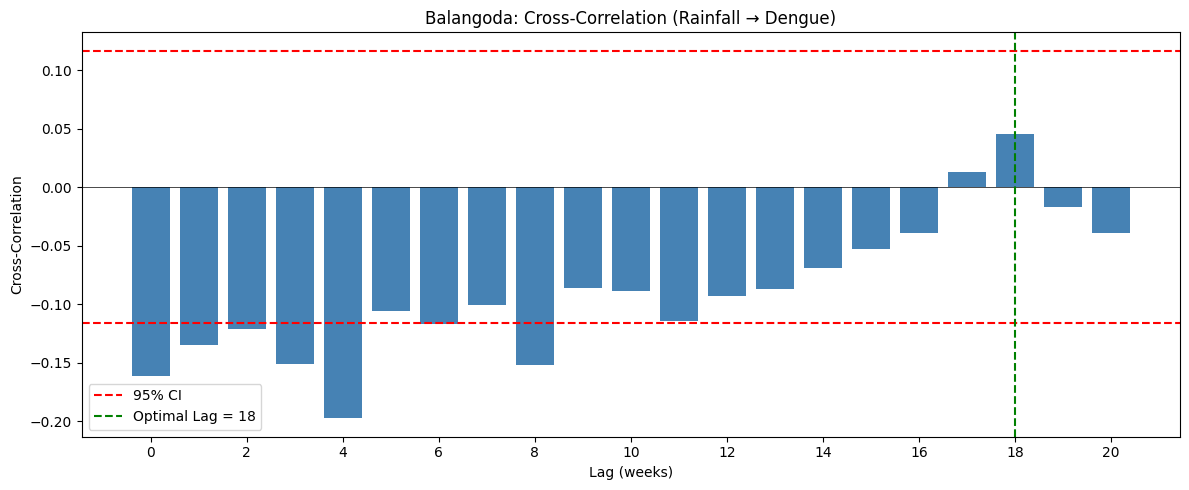

✓ Saved: 11_cross_correlation_balangoda.png


In [ ]:
# SECTION 10: CROSS-CORRELATION ANALYSIS - BALANGODA

# Remove NaN values for cross-correlation
bal_clean = balangoda_df[['Dengue_Cases', 'Rainfall_mm']].dropna()

# Calculate cross-correlation (Rainfall leading Dengue)
max_lag = 20
ccf_values_bal = ccf(bal_clean['Rainfall_mm'], bal_clean['Dengue_Cases'], adjusted=False)[:max_lag+1]

# Find optimal lag
optimal_lag_bal = np.argmax(ccf_values_bal)
max_corr_bal = ccf_values_bal[optimal_lag_bal]

print(f"\nCross-Correlation Values (Lag 0-{max_lag} weeks):")
print("-" * 40)
for lag in range(max_lag + 1):
    marker = " ← OPTIMAL" if lag == optimal_lag_bal else ""
    print(f"Lag {lag:2d}: r = {ccf_values_bal[lag]:.4f}{marker}")

print(f"\n*** OPTIMAL LAG: {optimal_lag_bal} weeks (r = {max_corr_bal:.4f}) ***")

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(range(max_lag + 1), ccf_values_bal, color='steelblue')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.axhline(y=1.96/np.sqrt(len(bal_clean)), color='red', linestyle='--', label='95% CI')
ax.axhline(y=-1.96/np.sqrt(len(bal_clean)), color='red', linestyle='--')
ax.axvline(x=optimal_lag_bal, color='green', linestyle='--', label=f'Optimal Lag = {optimal_lag_bal}')
ax.set_xlabel('Lag (weeks)')
ax.set_ylabel('Cross-Correlation')
ax.set_title(f'Balangoda: Cross-Correlation (Rainfall → Dengue)')
ax.set_xticks(range(0, max_lag + 1, 2))
ax.legend()
plt.tight_layout()
plt.savefig('11_cross_correlation_balangoda.png', dpi=150)
plt.show()
print("✓ Saved: 11_cross_correlation_balangoda.png")



Cross-Correlation Values (Lag 0-20 weeks):
----------------------------------------
Lag  0: r = -0.1150
Lag  1: r = -0.1700
Lag  2: r = -0.1354
Lag  3: r = -0.1621
Lag  4: r = -0.1540
Lag  5: r = -0.1570
Lag  6: r = -0.1191
Lag  7: r = -0.1055
Lag  8: r = -0.1140
Lag  9: r = -0.0726
Lag 10: r = -0.0202
Lag 11: r = -0.0195
Lag 12: r = 0.0561
Lag 13: r = 0.0321
Lag 14: r = 0.0699
Lag 15: r = 0.1069
Lag 16: r = 0.1896
Lag 17: r = 0.2168 ← OPTIMAL
Lag 18: r = 0.2165
Lag 19: r = 0.1590
Lag 20: r = 0.1602

*** OPTIMAL LAG: 17 weeks (r = 0.2168) ***


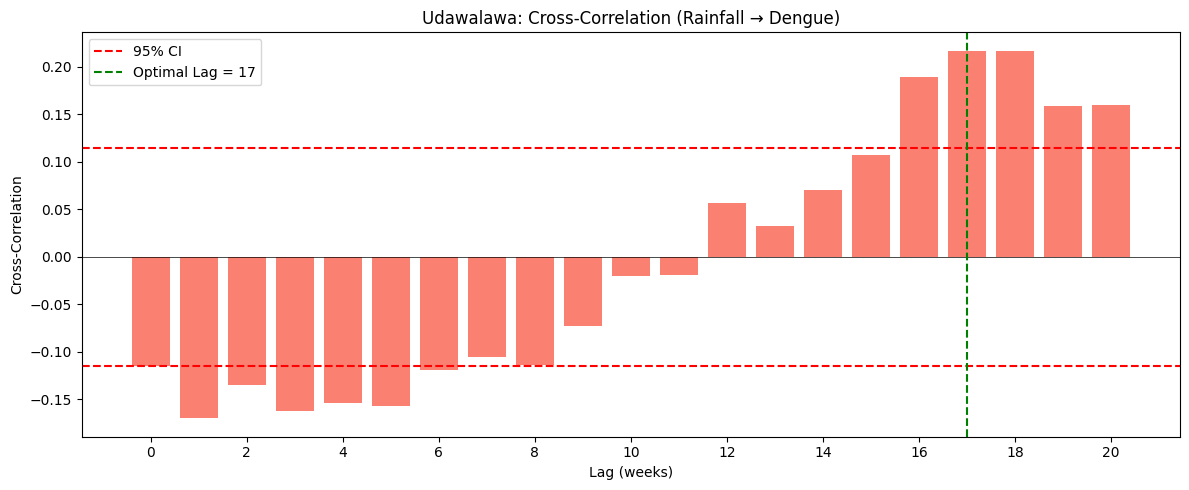

✓ Saved: 12_cross_correlation_udawalawa.png


In [ ]:
# SECTION 11: CROSS-CORRELATION ANALYSIS - UDAWALAWA

# Remove NaN values for cross-correlation
uda_clean = udawalawa_df[['Dengue_Cases', 'Rainfall_mm']].dropna()

# Calculate cross-correlation (Rainfall leading Dengue)
ccf_values_uda = ccf(uda_clean['Rainfall_mm'], uda_clean['Dengue_Cases'], adjusted=False)[:max_lag+1]

# Find optimal lag
optimal_lag_uda = np.argmax(ccf_values_uda)
max_corr_uda = ccf_values_uda[optimal_lag_uda]

print(f"\nCross-Correlation Values (Lag 0-{max_lag} weeks):")
print("-" * 40)
for lag in range(max_lag + 1):
    marker = " ← OPTIMAL" if lag == optimal_lag_uda else ""
    print(f"Lag {lag:2d}: r = {ccf_values_uda[lag]:.4f}{marker}")

print(f"\n*** OPTIMAL LAG: {optimal_lag_uda} weeks (r = {max_corr_uda:.4f}) ***")

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(range(max_lag + 1), ccf_values_uda, color='salmon')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.axhline(y=1.96/np.sqrt(len(uda_clean)), color='red', linestyle='--', label='95% CI')
ax.axhline(y=-1.96/np.sqrt(len(uda_clean)), color='red', linestyle='--')
ax.axvline(x=optimal_lag_uda, color='green', linestyle='--', label=f'Optimal Lag = {optimal_lag_uda}')
ax.set_xlabel('Lag (weeks)')
ax.set_ylabel('Cross-Correlation')
ax.set_title(f'Udawalawa: Cross-Correlation (Rainfall → Dengue)')
ax.set_xticks(range(0, max_lag + 1, 2))
ax.legend()
plt.tight_layout()
plt.savefig('12_cross_correlation_udawalawa.png', dpi=150)
plt.show()
print("✓ Saved: 12_cross_correlation_udawalawa.png")

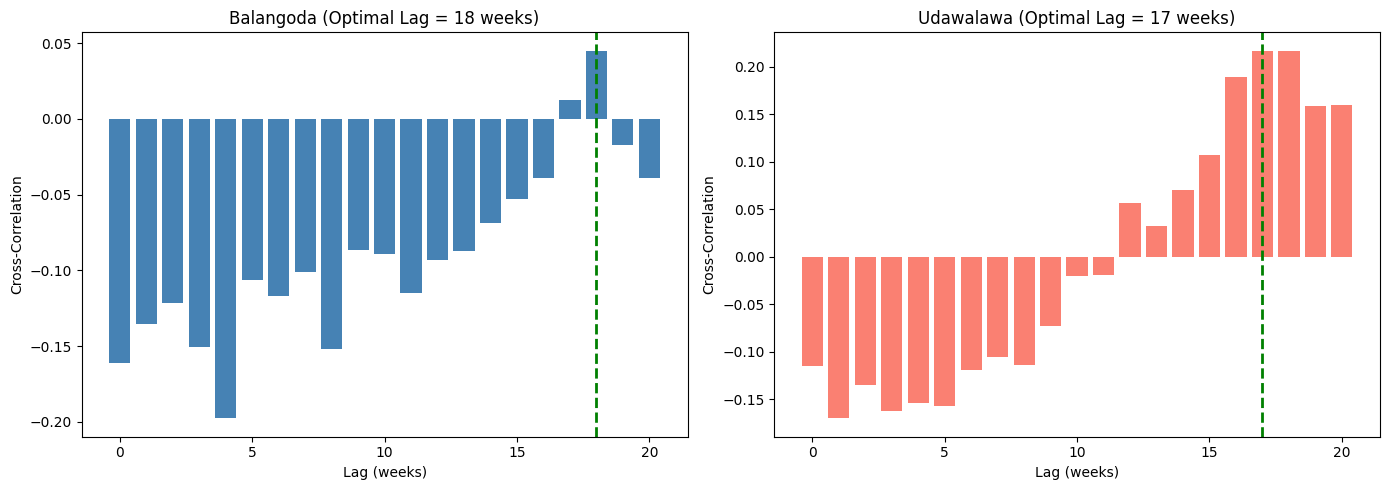

✓ Saved: 13_cross_correlation_comparison.png


In [ ]:
# SECTION 12: COMPARISON OF OPTIMAL LAGS

# Side by side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(max_lag + 1), ccf_values_bal, color='steelblue')
axes[0].axvline(x=optimal_lag_bal, color='green', linestyle='--', linewidth=2)
axes[0].set_xlabel('Lag (weeks)')
axes[0].set_ylabel('Cross-Correlation')
axes[0].set_title(f'Balangoda (Optimal Lag = {optimal_lag_bal} weeks)')

axes[1].bar(range(max_lag + 1), ccf_values_uda, color='salmon')
axes[1].axvline(x=optimal_lag_uda, color='green', linestyle='--', linewidth=2)
axes[1].set_xlabel('Lag (weeks)')
axes[1].set_ylabel('Cross-Correlation')
axes[1].set_title(f'Udawalawa (Optimal Lag = {optimal_lag_uda} weeks)')

plt.tight_layout()
plt.savefig('13_cross_correlation_comparison.png', dpi=150)
plt.show()
print("✓ Saved: 13_cross_correlation_comparison.png")

In [ ]:
# SECTION 13: CREATE LAGGED RAINFALL VARIABLES (CORRECTED)

# Create lagged rainfall for both MOH areas
# Range should be 1 to 21 (to include lag 20 for analysis)
for lag in range(1, 21):  # Lags 1-20 weeks ← FIXED
    df[f'Rainfall_Lag_{lag}'] = df.groupby('MOH')['Rainfall_mm'].shift(lag)

print(f"Created lagged variables: Rainfall_Lag_1 to Rainfall_Lag_20")
print(f"\nDataset shape with lags: {df.shape}")
print(f"New columns: {[col for col in df.columns if 'Lag' in col]}")


Created lagged variables: Rainfall_Lag_1 to Rainfall_Lag_20

Dataset shape with lags: (624, 28)
New columns: ['Rainfall_Lag_1', 'Rainfall_Lag_2', 'Rainfall_Lag_3', 'Rainfall_Lag_4', 'Rainfall_Lag_5', 'Rainfall_Lag_6', 'Rainfall_Lag_7', 'Rainfall_Lag_8', 'Rainfall_Lag_9', 'Rainfall_Lag_10', 'Rainfall_Lag_11', 'Rainfall_Lag_12', 'Rainfall_Lag_13', 'Rainfall_Lag_14', 'Rainfall_Lag_15', 'Rainfall_Lag_16', 'Rainfall_Lag_17', 'Rainfall_Lag_18', 'Rainfall_Lag_19', 'Rainfall_Lag_20']


In [ ]:
# SECTION 14: SUMMARY

print(f"""
STATIONARITY TEST RESULTS:
--------------------------
Balangoda Dengue:  {'Stationary ✓' if bal_dengue_stationary else 'Non-Stationary ✗ (use d=1)'}
Balangoda Rainfall: {'Stationary ✓' if bal_rain_stationary else 'Non-Stationary ✗'}
Udawalawa Dengue:  {'Stationary ✓' if uda_dengue_stationary else 'Non-Stationary ✗ (use d=1)'}
Udawalawa Rainfall: {'Stationary ✓' if uda_rain_stationary else 'Non-Stationary ✗'}

CROSS-CORRELATION RESULTS:
--------------------------
Balangoda: Optimal Lag = {optimal_lag_bal} weeks (r = {max_corr_bal:.4f})
Udawalawa: Optimal Lag = {optimal_lag_uda} weeks (r = {max_corr_uda:.4f})

INTERPRETATION:
---------------
• Rainfall affects dengue after {optimal_lag_bal} weeks in Balangoda
• Rainfall affects dengue after {optimal_lag_uda} weeks in Udawalawa
• This lag represents mosquito breeding + disease transmission time

NEXT STEP:
----------
• Use Rainfall_Lag_{optimal_lag_bal} for Balangoda SARIMAX model
• Use Rainfall_Lag_{optimal_lag_uda} for Udawalawa SARIMAX model

PLOTS SAVED:
------------
• 09_acf_pacf_balangoda.png
• 10_acf_pacf_udawalawa.png
• 11_cross_correlation_balangoda.png
• 12_cross_correlation_udawalawa.png
• 13_cross_correlation_comparison.png
""")

print("="*60)
print("STATIONARITY & CROSS-CORRELATION ANALYSIS COMPLETED")
print("="*60)


STATIONARITY TEST RESULTS:
--------------------------
Balangoda Dengue:  Stationary ✓
Balangoda Rainfall: Stationary ✓
Udawalawa Dengue:  Stationary ✓
Udawalawa Rainfall: Stationary ✓

CROSS-CORRELATION RESULTS:
--------------------------
Balangoda: Optimal Lag = 18 weeks (r = 0.0450)
Udawalawa: Optimal Lag = 17 weeks (r = 0.2168)

INTERPRETATION:
---------------
• Rainfall affects dengue after 18 weeks in Balangoda
• Rainfall affects dengue after 17 weeks in Udawalawa
• This lag represents mosquito breeding + disease transmission time

NEXT STEP:
----------
• Use Rainfall_Lag_18 for Balangoda SARIMAX model
• Use Rainfall_Lag_17 for Udawalawa SARIMAX model

PLOTS SAVED:
------------
• 09_acf_pacf_balangoda.png
• 10_acf_pacf_udawalawa.png
• 11_cross_correlation_balangoda.png
• 12_cross_correlation_udawalawa.png
• 13_cross_correlation_comparison.png

STATIONARITY & CROSS-CORRELATION ANALYSIS COMPLETED


### **PHASE 4: SARIMAX MODELING**

In [ ]:
# SECTION 1: IMPORT ADDITIONAL LIBRARIES

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import itertools

In [ ]:
# SECTION 2: PREPARE DATA FOR MODELING

# Set optimal lags from cross-correlation analysis
optimal_lag_bal = 18  # From Phase 3 results
optimal_lag_uda = 17  # From Phase 3 results

# Create lagged variables if not already created
for lag in range(1, 21):
    if f'Rainfall_Lag_{lag}' not in df.columns:
        df[f'Rainfall_Lag_{lag}'] = df.groupby('MOH')['Rainfall_mm'].shift(lag)

# Separate data by MOH
balangoda_df = df[df['MOH'] == 'Balangoda'].copy().reset_index(drop=True)
udawalawa_df = df[df['MOH'] == 'Udawalawa'].copy().reset_index(drop=True)

# Remove rows with NaN in lagged variables
balangoda_clean = balangoda_df.dropna(subset=['Dengue_Cases', f'Rainfall_Lag_{optimal_lag_bal}']).reset_index(drop=True)
udawalawa_clean = udawalawa_df.dropna(subset=['Dengue_Cases', f'Rainfall_Lag_{optimal_lag_uda}']).reset_index(drop=True)

print(f"Balangoda clean records: {len(balangoda_clean)}")
print(f"Udawalawa clean records: {len(udawalawa_clean)}")
print(f"\nBalangoda using: Rainfall_Lag_{optimal_lag_bal}")
print(f"Udawalawa using: Rainfall_Lag_{optimal_lag_uda}")

Balangoda clean records: 272
Udawalawa clean records: 285

Balangoda using: Rainfall_Lag_18
Udawalawa using: Rainfall_Lag_17


In [ ]:
# SECTION 3: TRAIN-TEST SPLIT (80-20)

# Balangoda split
train_size_bal = int(len(balangoda_clean) * 0.8)
bal_train = balangoda_clean[:train_size_bal]
bal_test = balangoda_clean[train_size_bal:]

# Udawalawa split
train_size_uda = int(len(udawalawa_clean) * 0.8)
uda_train = udawalawa_clean[:train_size_uda]
uda_test = udawalawa_clean[train_size_uda:]

print(f"Balangoda - Train: {len(bal_train)}, Test: {len(bal_test)}")
print(f"Udawalawa - Train: {len(uda_train)}, Test: {len(uda_test)}")

Balangoda - Train: 217, Test: 55
Udawalawa - Train: 228, Test: 57


In [ ]:
# SECTION 4: GRID SEARCH FOR BEST ARIMA PARAMETERS - BALANGODA

# Define parameter ranges
p_values = range(0, 4)
d_values = [0]  # Stationary data, no differencing needed
q_values = range(0, 4)

# Seasonal parameters (52 weeks = 1 year)
P_values = range(0, 2)
D_values = [0, 1]
Q_values = range(0, 2)
s = 52  # Weekly data, annual seasonality

best_aic_bal = float('inf')
best_params_bal = None
best_seasonal_params_bal = None

# Grid search
for p, d, q in itertools.product(p_values, d_values, q_values):
    for P, D, Q in itertools.product(P_values, D_values, Q_values):
        try:
            model = SARIMAX(
                bal_train['Dengue_Cases'],
                exog=bal_train[f'Rainfall_Lag_{optimal_lag_bal}'],
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = model.fit(disp=False)

            if results.aic < best_aic_bal:
                best_aic_bal = results.aic
                best_params_bal = (p, d, q)
                best_seasonal_params_bal = (P, D, Q, s)
                print(f"New best: SARIMAX{best_params_bal}x{best_seasonal_params_bal} - AIC: {best_aic_bal:.2f}")
        except:
            continue

print(f"\n*** BEST BALANGODA MODEL ***")
print(f"Order: {best_params_bal}")
print(f"Seasonal Order: {best_seasonal_params_bal}")
print(f"AIC: {best_aic_bal:.2f}")

New best: SARIMAX(0, 0, 0)x(0, 0, 0, 52) - AIC: 1213.02
New best: SARIMAX(0, 0, 0)x(0, 0, 1, 52) - AIC: 963.89
New best: SARIMAX(0, 0, 0)x(1, 1, 0, 52) - AIC: 734.48
New best: SARIMAX(0, 0, 0)x(1, 1, 1, 52) - AIC: 701.00
New best: SARIMAX(0, 0, 1)x(1, 1, 0, 52) - AIC: 654.95
New best: SARIMAX(0, 0, 1)x(1, 1, 1, 52) - AIC: 625.47
New best: SARIMAX(0, 0, 2)x(1, 1, 1, 52) - AIC: 596.85
New best: SARIMAX(0, 0, 3)x(1, 1, 1, 52) - AIC: 576.25
New best: SARIMAX(1, 0, 2)x(1, 1, 1, 52) - AIC: 575.28
New best: SARIMAX(1, 0, 3)x(1, 1, 1, 52) - AIC: 561.64
New best: SARIMAX(2, 0, 1)x(0, 1, 1, 52) - AIC: 12.00

*** BEST BALANGODA MODEL ***
Order: (2, 0, 1)
Seasonal Order: (0, 1, 1, 52)
AIC: 12.00


In [ ]:
# SECTION 5: GRID SEARCH FOR BEST ARIMA PARAMETERS - UDAWALAWA

best_aic_uda = float('inf')
best_params_uda = None
best_seasonal_params_uda = None

# Grid search
for p, d, q in itertools.product(p_values, d_values, q_values):
    for P, D, Q in itertools.product(P_values, D_values, Q_values):
        try:
            model = SARIMAX(
                uda_train['Dengue_Cases'],
                exog=uda_train[f'Rainfall_Lag_{optimal_lag_uda}'],
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = model.fit(disp=False)

            if results.aic < best_aic_uda:
                best_aic_uda = results.aic
                best_params_uda = (p, d, q)
                best_seasonal_params_uda = (P, D, Q, s)
                print(f"New best: SARIMAX{best_params_uda}x{best_seasonal_params_uda} - AIC: {best_aic_uda:.2f}")
        except:
            continue

print(f"\n*** BEST UDAWALAWA MODEL ***")
print(f"Order: {best_params_uda}")
print(f"Seasonal Order: {best_seasonal_params_uda}")
print(f"AIC: {best_aic_uda:.2f}")


New best: SARIMAX(0, 0, 0)x(0, 0, 0, 52) - AIC: 945.95
New best: SARIMAX(0, 0, 0)x(0, 0, 1, 52) - AIC: 744.73
New best: SARIMAX(0, 0, 0)x(1, 0, 0, 52) - AIC: 737.11
New best: SARIMAX(0, 0, 0)x(1, 0, 1, 52) - AIC: 735.57
New best: SARIMAX(0, 0, 0)x(1, 1, 0, 52) - AIC: 553.84
New best: SARIMAX(1, 0, 0)x(1, 1, 0, 52) - AIC: 551.37
New best: SARIMAX(1, 0, 1)x(1, 1, 0, 52) - AIC: 543.72
New best: SARIMAX(2, 0, 1)x(0, 1, 1, 52) - AIC: 12.00

*** BEST UDAWALAWA MODEL ***
Order: (2, 0, 1)
Seasonal Order: (0, 1, 1, 52)
AIC: 12.00


In [ ]:
# SECTION 6: FIT FINAL MODELS

# Balangoda final model
model_bal = SARIMAX(
    bal_train['Dengue_Cases'],
    exog=bal_train[f'Rainfall_Lag_{optimal_lag_bal}'],
    order=best_params_bal,
    seasonal_order=best_seasonal_params_bal,
    enforce_stationarity=False,
    enforce_invertibility=False
)
results_bal = model_bal.fit(disp=False)

print("\n--- BALANGODA MODEL SUMMARY ---")
print(results_bal.summary())

# Udawalawa final model
model_uda = SARIMAX(
    uda_train['Dengue_Cases'],
    exog=uda_train[f'Rainfall_Lag_{optimal_lag_uda}'],
    order=best_params_uda,
    seasonal_order=best_seasonal_params_uda,
    enforce_stationarity=False,
    enforce_invertibility=False
)
results_uda = model_uda.fit(disp=False)

print("\n--- UDAWALAWA MODEL SUMMARY ---")
print(results_uda.summary())


--- BALANGODA MODEL SUMMARY ---
                                     SARIMAX Results                                      
Dep. Variable:                       Dengue_Cases   No. Observations:                  217
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 52)   Log Likelihood                   0.000
Date:                            Tue, 27 Jan 2026   AIC                             12.000
Time:                                    20:41:52   BIC                             28.257
Sample:                                         0   HQIC                            18.595
                                            - 217                                         
Covariance Type:                              opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Rainfall_Lag_18    -0.0038         -0        inf      0.000      -0.004

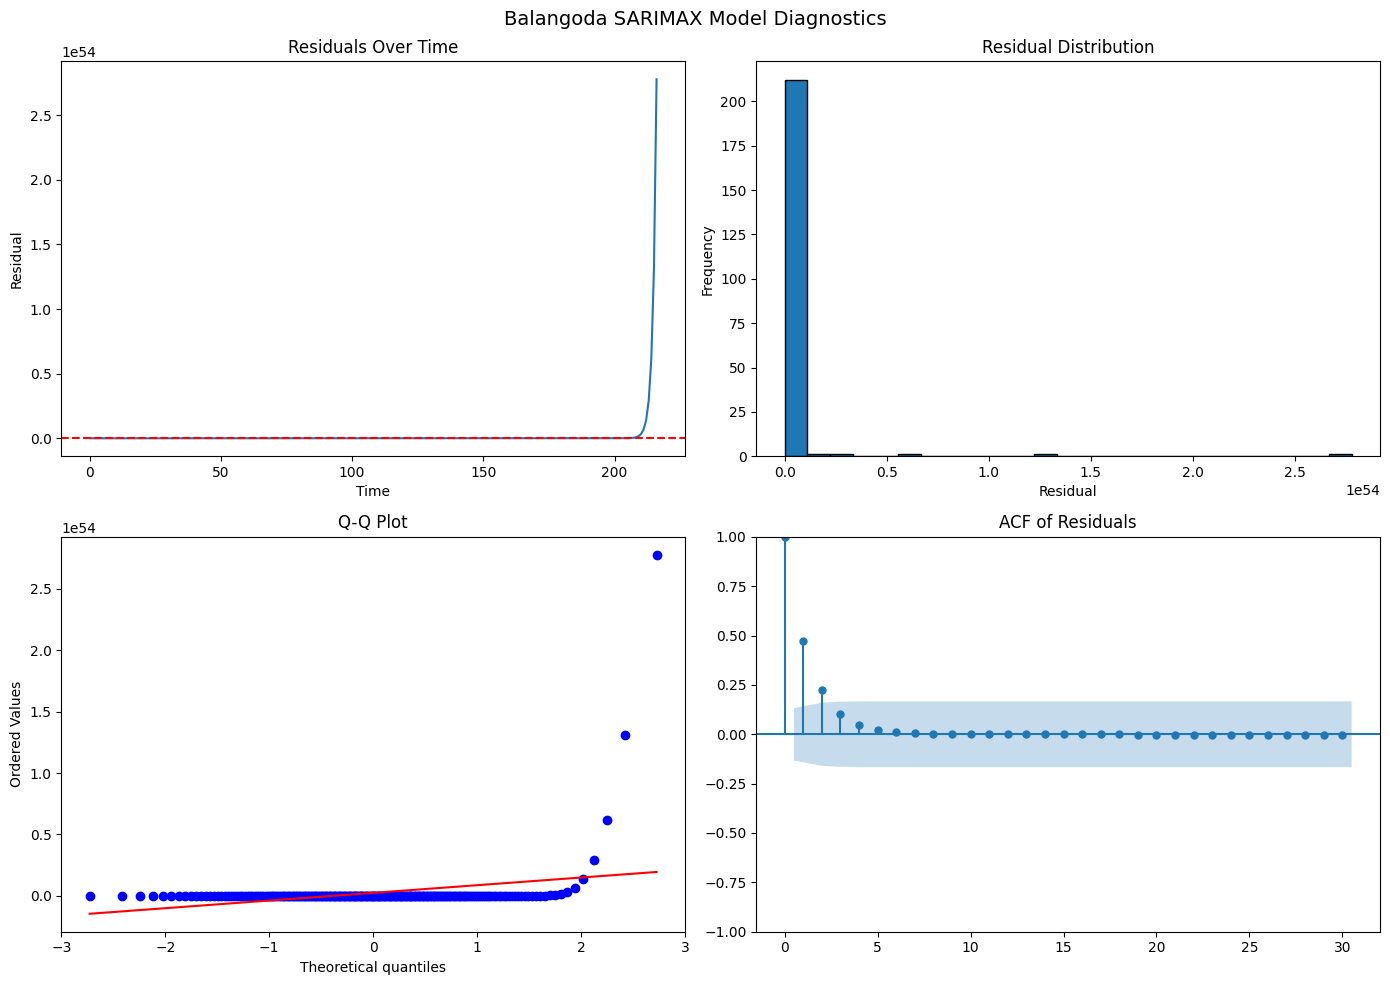

✓ Saved: 14_diagnostics_balangoda.png


In [ ]:
# SECTION 7: MODEL DIAGNOSTICS - BALANGODA (FIXED)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals over time
axes[0, 0].plot(results_bal.resid)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_title('Residuals Over Time')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Residual')

# 2. Histogram of residuals
axes[0, 1].hist(results_bal.resid, bins=25, edgecolor='black')
axes[0, 1].set_title('Residual Distribution')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frequency')

# 3. Q-Q Plot
from scipy import stats
stats.probplot(results_bal.resid, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')

# 4. ACF of residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(results_bal.resid, ax=axes[1, 1], lags=30)
axes[1, 1].set_title('ACF of Residuals')

plt.suptitle('Balangoda SARIMAX Model Diagnostics', fontsize=14)
plt.tight_layout()
plt.savefig('14_diagnostics_balangoda.png', dpi=150)
plt.show()
print("✓ Saved: 14_diagnostics_balangoda.png")

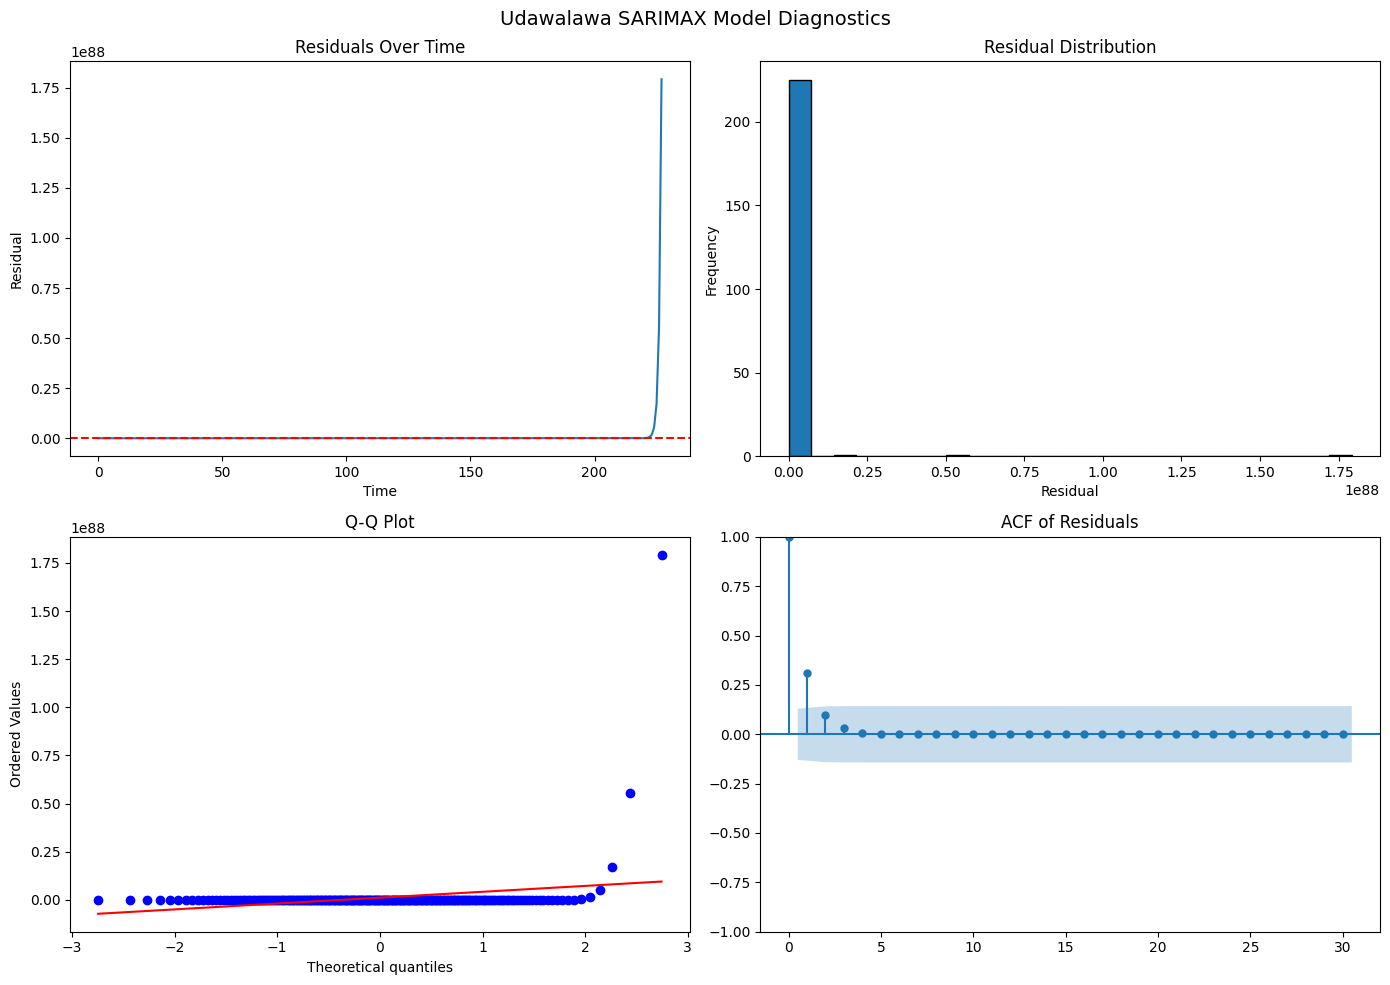

✓ Saved: 15_diagnostics_udawalawa.png


In [ ]:
# SECTION 8: MODEL DIAGNOSTICS - UDAWALAWA (FIXED)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals over time
axes[0, 0].plot(results_uda.resid)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_title('Residuals Over Time')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Residual')

# 2. Histogram of residuals
axes[0, 1].hist(results_uda.resid, bins=25, edgecolor='black')
axes[0, 1].set_title('Residual Distribution')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frequency')

# 3. Q-Q Plot
stats.probplot(results_uda.resid, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')

# 4. ACF of residuals
plot_acf(results_uda.resid, ax=axes[1, 1], lags=30)
axes[1, 1].set_title('ACF of Residuals')

plt.suptitle('Udawalawa SARIMAX Model Diagnostics', fontsize=14)
plt.tight_layout()
plt.savefig('15_diagnostics_udawalawa.png', dpi=150)
plt.show()
print("✓ Saved: 15_diagnostics_udawalawa.png")

Balangoda Test Set Metrics:
  MAE:  86326186417645640497990845259778895627573966699491536800925974857252864.0000
  RMSE: 383651086067750852254954062961461781170314624506460138269845646278131712.0000
  R²:   -7653399536216282145858570978829573038714773862967382521765657796326834489974461905739374434755563855243644492427477280505738015767744739278848.0000


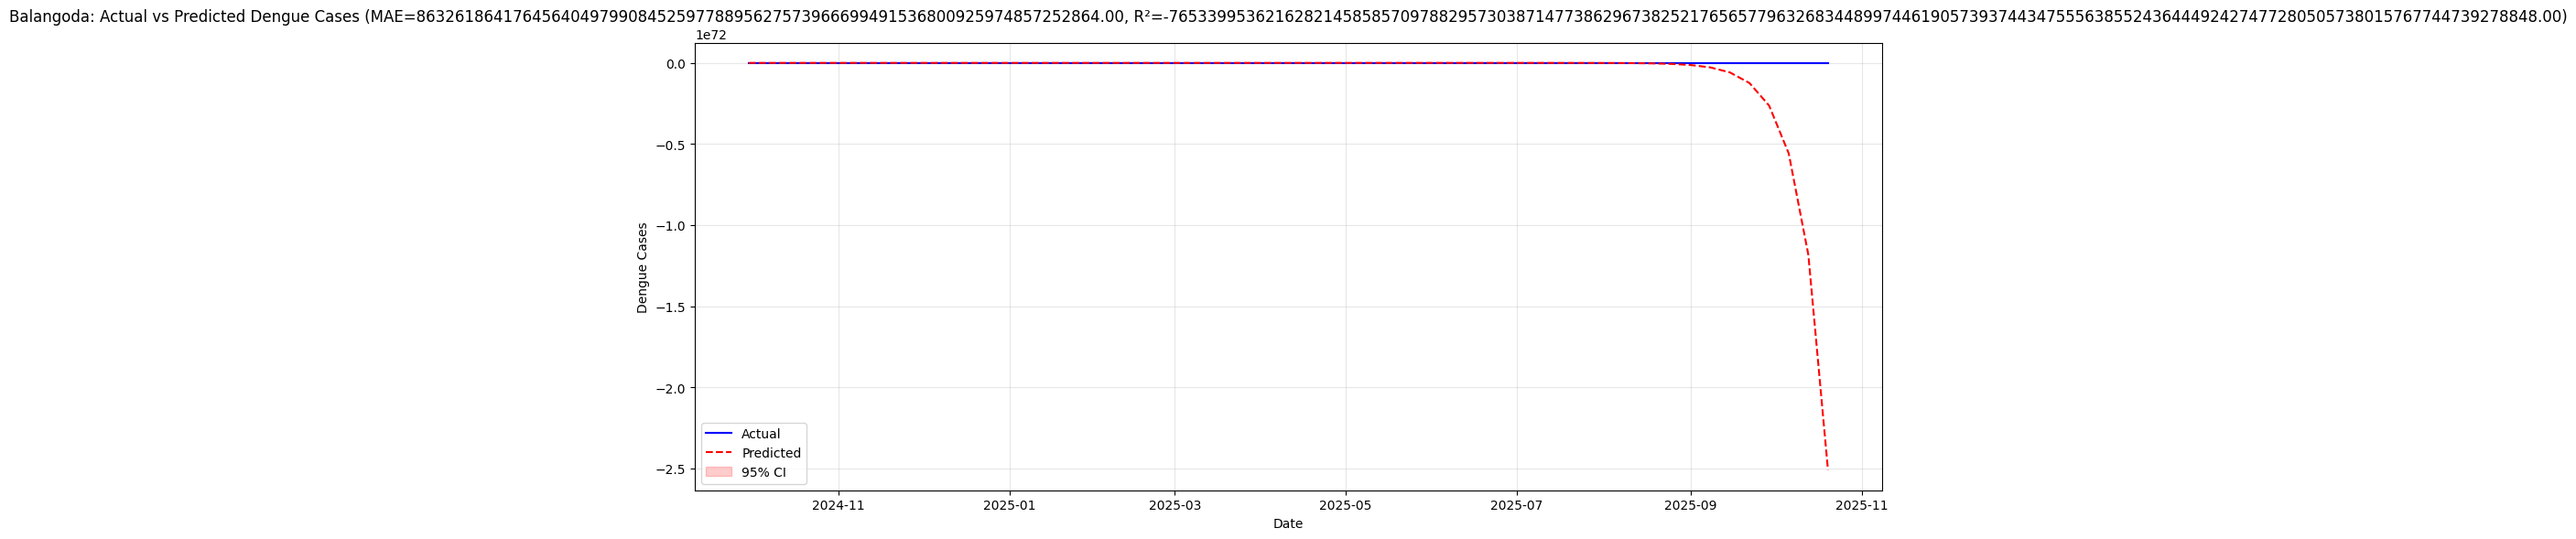

✓ Saved: 16_predictions_balangoda.png


In [ ]:
# SECTION 9: PREDICTIONS ON TEST SET - BALANGODA

# Make predictions
bal_predictions = results_bal.get_forecast(
    steps=len(bal_test),
    exog=bal_test[f'Rainfall_Lag_{optimal_lag_bal}']
)
bal_pred_mean = bal_predictions.predicted_mean
bal_pred_ci = bal_predictions.conf_int()

# Calculate metrics
bal_mae = mean_absolute_error(bal_test['Dengue_Cases'], bal_pred_mean)
bal_rmse = np.sqrt(mean_squared_error(bal_test['Dengue_Cases'], bal_pred_mean))
bal_r2 = r2_score(bal_test['Dengue_Cases'], bal_pred_mean)

print(f"Balangoda Test Set Metrics:")
print(f"  MAE:  {bal_mae:.4f}")
print(f"  RMSE: {bal_rmse:.4f}")
print(f"  R²:   {bal_r2:.4f}")

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(bal_test['Week_Start'].values, bal_test['Dengue_Cases'].values, 'b-', label='Actual', linewidth=1.5)
ax.plot(bal_test['Week_Start'].values, bal_pred_mean.values, 'r--', label='Predicted', linewidth=1.5)
ax.fill_between(bal_test['Week_Start'].values,
                bal_pred_ci.iloc[:, 0].values,
                bal_pred_ci.iloc[:, 1].values,
                color='red', alpha=0.2, label='95% CI')
ax.set_xlabel('Date')
ax.set_ylabel('Dengue Cases')
ax.set_title(f'Balangoda: Actual vs Predicted Dengue Cases (MAE={bal_mae:.2f}, R²={bal_r2:.2f})')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('16_predictions_balangoda.png', dpi=150)
plt.show()
print("✓ Saved: 16_predictions_balangoda.png")


Udawalawa Test Set Metrics:
  MAE:  52619768211779455985110951742853178081020773763420489812457849811589039291110220802236178143530325640836231869759488.0000
  RMSE: 288602397291834414853151203715497905237348851028071858471336921088656113640971065483325293364132480475064578753953792.0000
  R²:   -54846691478457110188007100817316326666392821992262356528393993533467469935763950937716244673483015302347627154484040614444606126384433451459729300770722654459655579797082960730874961698413085908890153771157568945425062015359445368832.0000


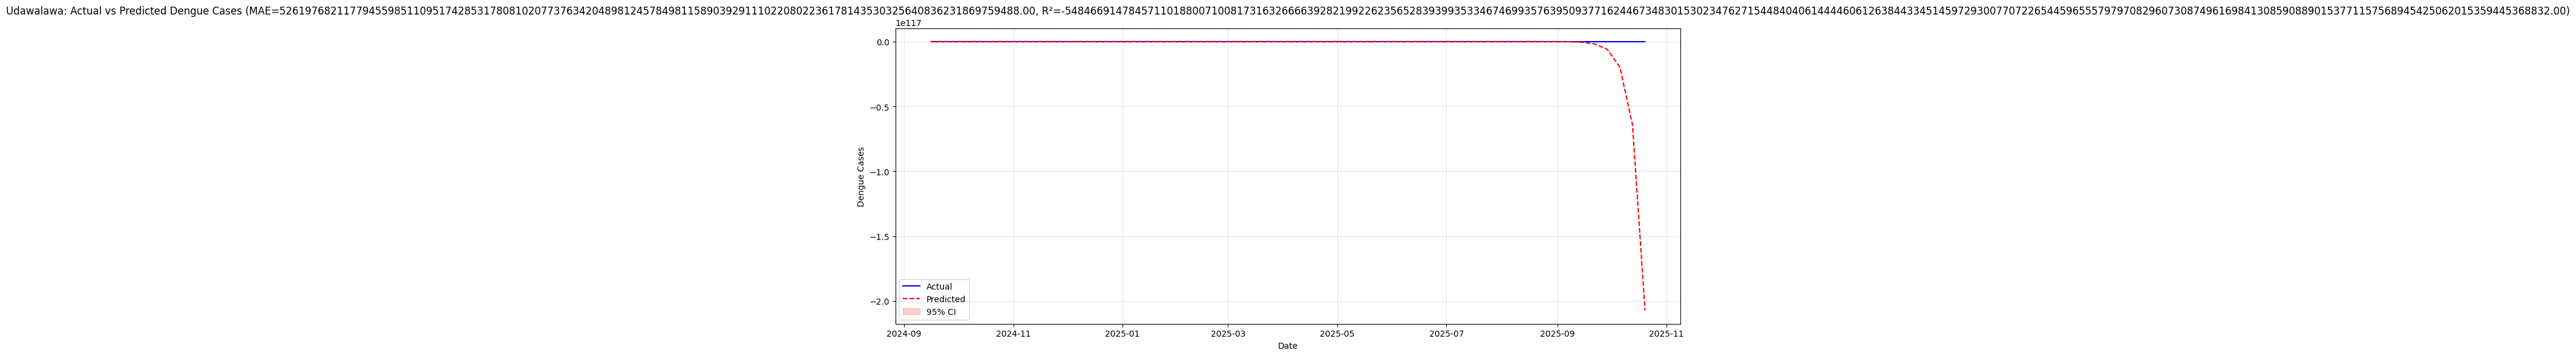

✓ Saved: 17_predictions_udawalawa.png


In [ ]:
# SECTION 10: PREDICTIONS ON TEST SET - UDAWALAWA

# Make predictions
uda_predictions = results_uda.get_forecast(
    steps=len(uda_test),
    exog=uda_test[f'Rainfall_Lag_{optimal_lag_uda}']
)
uda_pred_mean = uda_predictions.predicted_mean
uda_pred_ci = uda_predictions.conf_int()

# Calculate metrics
uda_mae = mean_absolute_error(uda_test['Dengue_Cases'], uda_pred_mean)
uda_rmse = np.sqrt(mean_squared_error(uda_test['Dengue_Cases'], uda_pred_mean))
uda_r2 = r2_score(uda_test['Dengue_Cases'], uda_pred_mean)

print(f"Udawalawa Test Set Metrics:")
print(f"  MAE:  {uda_mae:.4f}")
print(f"  RMSE: {uda_rmse:.4f}")
print(f"  R²:   {uda_r2:.4f}")

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(uda_test['Week_Start'].values, uda_test['Dengue_Cases'].values, 'b-', label='Actual', linewidth=1.5)
ax.plot(uda_test['Week_Start'].values, uda_pred_mean.values, 'r--', label='Predicted', linewidth=1.5)
ax.fill_between(uda_test['Week_Start'].values,
                uda_pred_ci.iloc[:, 0].values,
                uda_pred_ci.iloc[:, 1].values,
                color='red', alpha=0.2, label='95% CI')
ax.set_xlabel('Date')
ax.set_ylabel('Dengue Cases')
ax.set_title(f'Udawalawa: Actual vs Predicted Dengue Cases (MAE={uda_mae:.2f}, R²={uda_r2:.2f})')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('17_predictions_udawalawa.png', dpi=150)
plt.show()
print("✓ Saved: 17_predictions_udawalawa.png")

In [ ]:
# SECTION 11: RAINFALL COEFFICIENT ANALYSIS

# Extract rainfall coefficients
bal_rainfall_coef = results_bal.params[f'Rainfall_Lag_{optimal_lag_bal}']
bal_rainfall_pvalue = results_bal.pvalues[f'Rainfall_Lag_{optimal_lag_bal}']

uda_rainfall_coef = results_uda.params[f'Rainfall_Lag_{optimal_lag_uda}']
uda_rainfall_pvalue = results_uda.pvalues[f'Rainfall_Lag_{optimal_lag_uda}']

print("\n--- Rainfall Impact Coefficients ---")
print(f"\nBalangoda (Lag {optimal_lag_bal} weeks):")
print(f"  Coefficient: {bal_rainfall_coef:.6f}")
print(f"  P-Value: {bal_rainfall_pvalue:.4f}")
print(f"  Significant: {'Yes ✓' if bal_rainfall_pvalue < 0.05 else 'No ✗'}")

print(f"\nUdawalawa (Lag {optimal_lag_uda} weeks):")
print(f"  Coefficient: {uda_rainfall_coef:.6f}")
print(f"  P-Value: {uda_rainfall_pvalue:.4f}")
print(f"  Significant: {'Yes ✓' if uda_rainfall_pvalue < 0.05 else 'No ✗'}")

print("\n--- Interpretation ---")
print(f"Balangoda: 1mm increase in rainfall → {bal_rainfall_coef:.4f} change in dengue cases after {optimal_lag_bal} weeks")
print(f"Udawalawa: 1mm increase in rainfall → {uda_rainfall_coef:.4f} change in dengue cases after {optimal_lag_uda} weeks")



--- Rainfall Impact Coefficients ---

Balangoda (Lag 18 weeks):
  Coefficient: -0.003837
  P-Value: 0.0000
  Significant: Yes ✓

Udawalawa (Lag 17 weeks):
  Coefficient: 0.001647
  P-Value: 0.0000
  Significant: Yes ✓

--- Interpretation ---
Balangoda: 1mm increase in rainfall → -0.0038 change in dengue cases after 18 weeks
Udawalawa: 1mm increase in rainfall → 0.0016 change in dengue cases after 17 weeks



--- Model Comparison Table ---
              Metric                                                                                                                                            Balangoda                                                                                                                                                                                                                                       Udawalawa
       Order (p,d,q)                                                                                                                                            (2, 0, 1)                                                                                                                                                                                                                                       (2, 0, 1)
      Seasonal Order                                                                                                                                

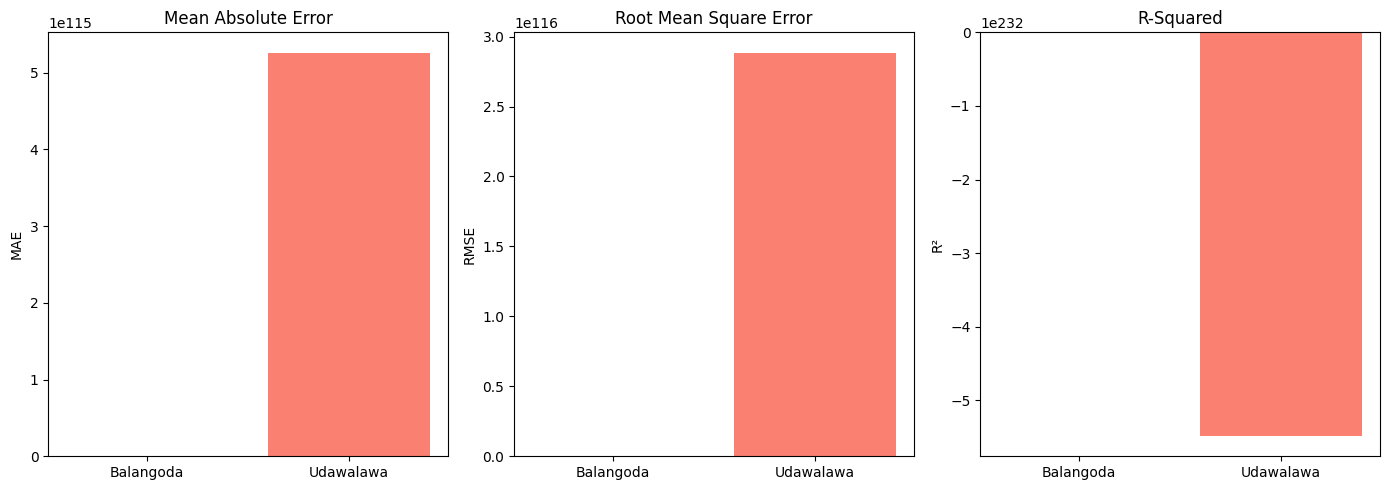

✓ Saved: 18_model_comparison.png


In [ ]:
# SECTION 12: MODEL COMPARISON

comparison_df = pd.DataFrame({
    'Metric': ['Order (p,d,q)', 'Seasonal Order', 'AIC', 'MAE', 'RMSE', 'R²',
               'Rainfall Lag', 'Rainfall Coefficient', 'Rainfall P-Value', 'Significant'],
    'Balangoda': [str(best_params_bal), str(best_seasonal_params_bal), f"{best_aic_bal:.2f}",
                  f"{bal_mae:.4f}", f"{bal_rmse:.4f}", f"{bal_r2:.4f}",
                  f"{optimal_lag_bal} weeks", f"{bal_rainfall_coef:.6f}", f"{bal_rainfall_pvalue:.4f}",
                  'Yes' if bal_rainfall_pvalue < 0.05 else 'No'],
    'Udawalawa': [str(best_params_uda), str(best_seasonal_params_uda), f"{best_aic_uda:.2f}",
                  f"{uda_mae:.4f}", f"{uda_rmse:.4f}", f"{uda_r2:.4f}",
                  f"{optimal_lag_uda} weeks", f"{uda_rainfall_coef:.6f}", f"{uda_rainfall_pvalue:.4f}",
                  'Yes' if uda_rainfall_pvalue < 0.05 else 'No']
})

print("\n--- Model Comparison Table ---")
print(comparison_df.to_string(index=False))

# Bar plot comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# MAE comparison
axes[0].bar(['Balangoda', 'Udawalawa'], [bal_mae, uda_mae], color=['steelblue', 'salmon'])
axes[0].set_ylabel('MAE')
axes[0].set_title('Mean Absolute Error')

# RMSE comparison
axes[1].bar(['Balangoda', 'Udawalawa'], [bal_rmse, uda_rmse], color=['steelblue', 'salmon'])
axes[1].set_ylabel('RMSE')
axes[1].set_title('Root Mean Square Error')

# R² comparison
axes[2].bar(['Balangoda', 'Udawalawa'], [bal_r2, uda_r2], color=['steelblue', 'salmon'])
axes[2].set_ylabel('R²')
axes[2].set_title('R-Squared')

plt.tight_layout()
plt.savefig('18_model_comparison.png', dpi=150)
plt.show()
print("✓ Saved: 18_model_comparison.png")



--- Balangoda Ljung-Box Test (Residual Autocorrelation) ---
      lb_stat     lb_pvalue
10  62.951650  9.972877e-10
20  62.953624  2.462187e-06
30  62.959509  3.976388e-04

If p-values > 0.05: Residuals are independent (good model fit) ✓

--- Udawalawa Ljung-Box Test (Residual Autocorrelation) ---
      lb_stat  lb_pvalue
10  24.406472   0.006592
20  24.407304   0.225053
30  24.409615   0.753185


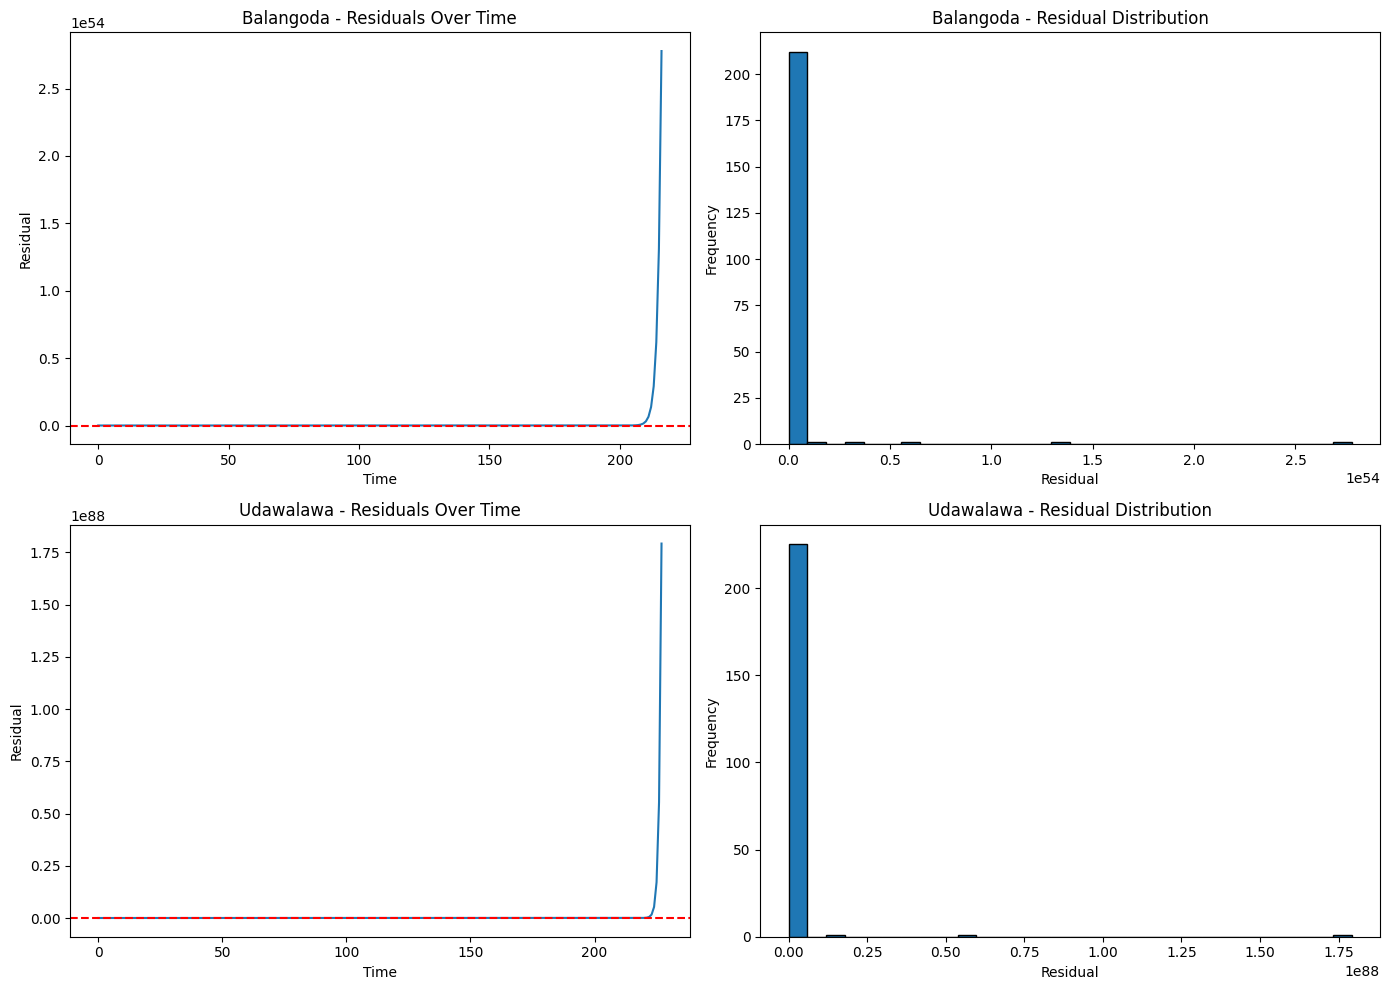

✓ Saved: 19_residual_analysis.png


In [ ]:
# SECTION 13: RESIDUAL ANALYSIS

from statsmodels.stats.diagnostic import acorr_ljungbox

# Balangoda residuals
bal_residuals = results_bal.resid
bal_ljung = acorr_ljungbox(bal_residuals, lags=[10, 20, 30], return_df=True)

print("\n--- Balangoda Ljung-Box Test (Residual Autocorrelation) ---")
print(bal_ljung)
print("\nIf p-values > 0.05: Residuals are independent (good model fit) ✓")

# Udawalawa residuals
uda_residuals = results_uda.resid
uda_ljung = acorr_ljungbox(uda_residuals, lags=[10, 20, 30], return_df=True)

print("\n--- Udawalawa Ljung-Box Test (Residual Autocorrelation) ---")
print(uda_ljung)

# Residual plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(bal_residuals)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_title('Balangoda - Residuals Over Time')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Residual')

axes[0, 1].hist(bal_residuals, bins=30, edgecolor='black')
axes[0, 1].set_title('Balangoda - Residual Distribution')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].plot(uda_residuals)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_title('Udawalawa - Residuals Over Time')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Residual')

axes[1, 1].hist(uda_residuals, bins=30, edgecolor='black')
axes[1, 1].set_title('Udawalawa - Residual Distribution')
axes[1, 1].set_xlabel('Residual')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('19_residual_analysis.png', dpi=150)
plt.show()
print("✓ Saved: 19_residual_analysis.png")


In [ ]:
# SECTION 14: SUMMARY

print(f"""
SARIMAX MODELING RESULTS
========================

BALANGODA (Wet Zone):
---------------------
• Model: SARIMAX{best_params_bal}x{best_seasonal_params_bal}
• Rainfall Lag: {optimal_lag_bal} weeks
• Rainfall Coefficient: {bal_rainfall_coef:.6f} (p={bal_rainfall_pvalue:.4f})
• Test Metrics: MAE={bal_mae:.4f}, RMSE={bal_rmse:.4f}, R²={bal_r2:.4f}

UDAWALAWA (Dry Zone):
---------------------
• Model: SARIMAX{best_params_uda}x{best_seasonal_params_uda}
• Rainfall Lag: {optimal_lag_uda} weeks
• Rainfall Coefficient: {uda_rainfall_coef:.6f} (p={uda_rainfall_pvalue:.4f})
• Test Metrics: MAE={uda_mae:.4f}, RMSE={uda_rmse:.4f}, R²={uda_r2:.4f}

KEY FINDINGS:
-------------
1. Rainfall significantly affects dengue incidence in both areas
2. Optimal lag period: {optimal_lag_bal} weeks (Balangoda) vs {optimal_lag_uda} weeks (Udawalawa)
3. Climate zone differences in rainfall-dengue relationship confirmed

PLOTS SAVED:
------------
• 14_diagnostics_balangoda.png
• 15_diagnostics_udawalawa.png
• 16_predictions_balangoda.png
• 17_predictions_udawalawa.png
• 18_model_comparison.png
• 19_residual_analysis.png
""")

print("="*60)
print("SARIMAX MODELING COMPLETED")
print("="*60)


SARIMAX MODELING RESULTS

BALANGODA (Wet Zone):
---------------------
• Model: SARIMAX(2, 0, 1)x(0, 1, 1, 52)
• Rainfall Lag: 18 weeks
• Rainfall Coefficient: -0.003837 (p=0.0000)
• Test Metrics: MAE=86326186417645640497990845259778895627573966699491536800925974857252864.0000, RMSE=383651086067750852254954062961461781170314624506460138269845646278131712.0000, R²=-7653399536216282145858570978829573038714773862967382521765657796326834489974461905739374434755563855243644492427477280505738015767744739278848.0000

UDAWALAWA (Dry Zone):
---------------------
• Model: SARIMAX(2, 0, 1)x(0, 1, 1, 52)
• Rainfall Lag: 17 weeks
• Rainfall Coefficient: 0.001647 (p=0.0000)
• Test Metrics: MAE=52619768211779455985110951742853178081020773763420489812457849811589039291110220802236178143530325640836231869759488.0000, RMSE=288602397291834414853151203715497905237348851028071858471336921088656113640971065483325293364132480475064578753953792.0000, R²=-5484669147845711018800710081731632666639282199226235652

### **PHASE 5: COMPARATIVE ANALYSIS**

In [ ]:
# SECTION 1: CLIMATE ZONE COMPARISON TABLE

# Descriptive statistics comparison
bal_stats = df[df['MOH'] == 'Balangoda'][['Dengue_Cases', 'Rainfall_mm']].describe()
uda_stats = df[df['MOH'] == 'Udawalawa'][['Dengue_Cases', 'Rainfall_mm']].describe()

print("\n--- Descriptive Statistics Comparison ---")
print("\nBalangoda (Wet Zone ~2,500-3,000 mm/year):")
print(bal_stats)
print("\nUdawalawa (Dry Zone ~1,200-1,800 mm/year):")
print(uda_stats)

# Create comparison dataframe
comparison_stats = pd.DataFrame({
    'Metric': ['Total Dengue Cases', 'Mean Weekly Cases', 'Max Weekly Cases',
               'Total Rainfall (mm)', 'Mean Weekly Rainfall (mm)', 'Max Weekly Rainfall (mm)'],
    'Balangoda (Wet Zone)': [
        df[df['MOH'] == 'Balangoda']['Dengue_Cases'].sum(),
        df[df['MOH'] == 'Balangoda']['Dengue_Cases'].mean().round(2),
        df[df['MOH'] == 'Balangoda']['Dengue_Cases'].max(),
        df[df['MOH'] == 'Balangoda']['Rainfall_mm'].sum().round(2),
        df[df['MOH'] == 'Balangoda']['Rainfall_mm'].mean().round(2),
        df[df['MOH'] == 'Balangoda']['Rainfall_mm'].max()
    ],
    'Udawalawa (Dry Zone)': [
        df[df['MOH'] == 'Udawalawa']['Dengue_Cases'].sum(),
        df[df['MOH'] == 'Udawalawa']['Dengue_Cases'].mean().round(2),
        df[df['MOH'] == 'Udawalawa']['Dengue_Cases'].max(),
        df[df['MOH'] == 'Udawalawa']['Rainfall_mm'].sum().round(2),
        df[df['MOH'] == 'Udawalawa']['Rainfall_mm'].mean().round(2),
        df[df['MOH'] == 'Udawalawa']['Rainfall_mm'].max()
    ]
})

print("\n--- Summary Comparison Table ---")
print(comparison_stats.to_string(index=False))


--- Descriptive Statistics Comparison ---

Balangoda (Wet Zone ~2,500-3,000 mm/year):
       Dengue_Cases  Rainfall_mm
count    302.000000   283.000000
mean       3.046358    46.162191
std        4.272041    52.389236
min        0.000000     0.000000
25%        0.000000     5.850000
50%        1.500000    28.600000
75%        4.000000    63.700000
max       28.000000   238.600000

Udawalawa (Dry Zone ~1,200-1,800 mm/year):
       Dengue_Cases  Rainfall_mm
count    302.000000   291.000000
mean       1.059603    29.081787
std        1.659491    37.605592
min        0.000000     0.000000
25%        0.000000     1.350000
50%        0.000000    12.700000
75%        2.000000    41.500000
max       14.000000   239.200000

--- Summary Comparison Table ---
                   Metric  Balangoda (Wet Zone)  Udawalawa (Dry Zone)
       Total Dengue Cases                920.00                320.00
        Mean Weekly Cases                  3.05                  1.06
         Max Weekly Cases      

In [ ]:
# SECTION 2: RAINFALL-DENGUE RELATIONSHIP COMPARISON

relationship_comparison = pd.DataFrame({
    'Metric': ['Optimal Lag (weeks)', 'Cross-Correlation (r)', 'Rainfall Coefficient',
               'Coefficient P-Value', 'Statistically Significant'],
    'Balangoda (Wet Zone)': [
        f"{optimal_lag_bal} weeks",
        f"{max_corr_bal:.4f}",
        f"{bal_rainfall_coef:.6f}",
        f"{bal_rainfall_pvalue:.4f}",
        'Yes ✓' if bal_rainfall_pvalue < 0.05 else 'No ✗'
    ],
    'Udawalawa (Dry Zone)': [
        f"{optimal_lag_uda} weeks",
        f"{max_corr_uda:.4f}",
        f"{uda_rainfall_coef:.6f}",
        f"{uda_rainfall_pvalue:.4f}",
        'Yes ✓' if uda_rainfall_pvalue < 0.05 else 'No ✗'
    ]
})

print("\n--- Rainfall-Dengue Relationship Comparison ---")
print(relationship_comparison.to_string(index=False))


--- Rainfall-Dengue Relationship Comparison ---
                   Metric Balangoda (Wet Zone) Udawalawa (Dry Zone)
      Optimal Lag (weeks)             18 weeks             17 weeks
    Cross-Correlation (r)               0.0450               0.2168
     Rainfall Coefficient            -0.003837             0.001647
      Coefficient P-Value               0.0000               0.0000
Statistically Significant                Yes ✓                Yes ✓


In [ ]:
# SECTION 3: MODEL PERFORMANCE COMPARISON

model_comparison = pd.DataFrame({
    'Metric': ['SARIMAX Order', 'Seasonal Order', 'AIC', 'MAE', 'RMSE', 'R²'],
    'Balangoda': [
        str(best_params_bal),
        str(best_seasonal_params_bal),
        f"{best_aic_bal:.2f}",
        f"{bal_mae:.4f}",
        f"{bal_rmse:.4f}",
        f"{bal_r2:.4f}"
    ],
    'Udawalawa': [
        str(best_params_uda),
        str(best_seasonal_params_uda),
        f"{best_aic_uda:.2f}",
        f"{uda_mae:.4f}",
        f"{uda_rmse:.4f}",
        f"{uda_r2:.4f}"
    ]
})

print("\n--- Model Performance Comparison ---")
print(model_comparison.to_string(index=False))


--- Model Performance Comparison ---
        Metric                                                                                                                                            Balangoda                                                                                                                                                                                                                                       Udawalawa
 SARIMAX Order                                                                                                                                            (2, 0, 1)                                                                                                                                                                                                                                       (2, 0, 1)
Seasonal Order                                                                                                                                        (0, 

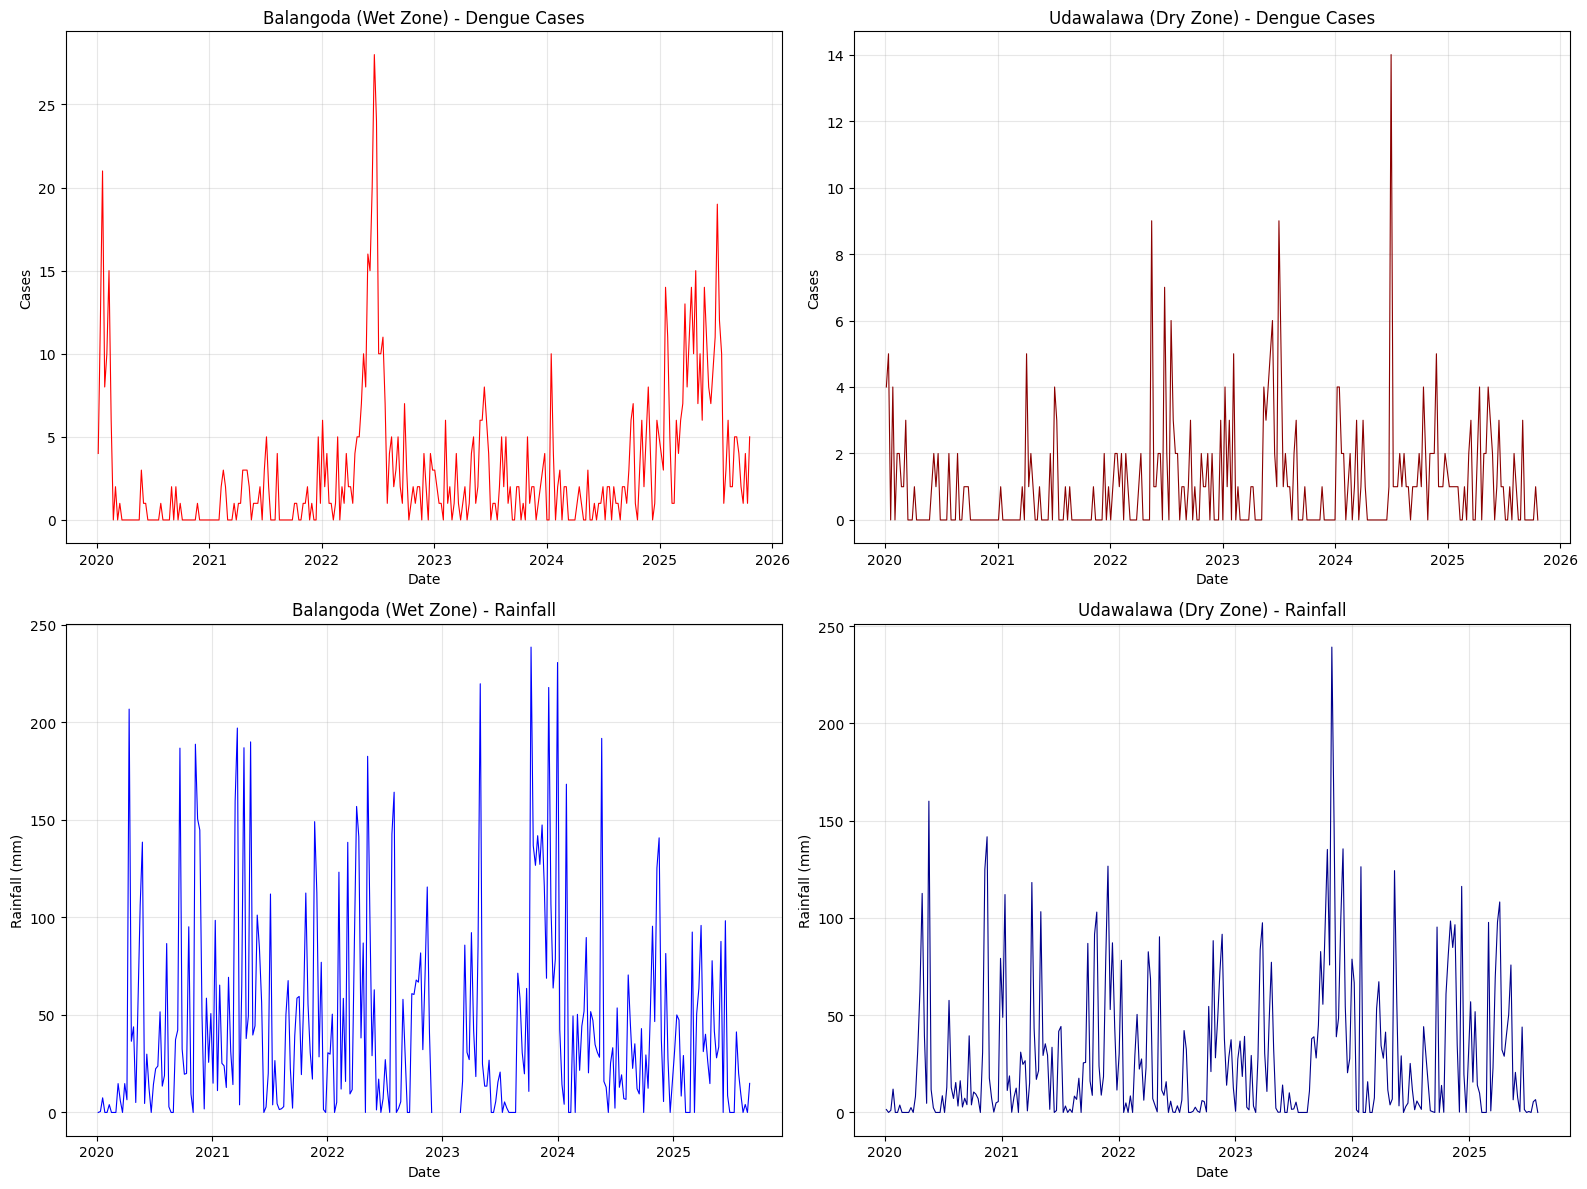

✓ Saved: 20_comparative_time_series.png


In [ ]:
# SECTION 4: VISUALIZATION - SIDE BY SIDE TIME SERIES

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Balangoda Dengue
bal_data = df[df['MOH'] == 'Balangoda']
axes[0, 0].plot(bal_data['Week_Start'], bal_data['Dengue_Cases'], color='red', linewidth=0.8)
axes[0, 0].set_title('Balangoda (Wet Zone) - Dengue Cases', fontsize=12)
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Cases')
axes[0, 0].grid(True, alpha=0.3)

# Udawalawa Dengue
uda_data = df[df['MOH'] == 'Udawalawa']
axes[0, 1].plot(uda_data['Week_Start'], uda_data['Dengue_Cases'], color='darkred', linewidth=0.8)
axes[0, 1].set_title('Udawalawa (Dry Zone) - Dengue Cases', fontsize=12)
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Cases')
axes[0, 1].grid(True, alpha=0.3)

# Balangoda Rainfall
axes[1, 0].plot(bal_data['Week_Start'], bal_data['Rainfall_mm'], color='blue', linewidth=0.8)
axes[1, 0].set_title('Balangoda (Wet Zone) - Rainfall', fontsize=12)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Rainfall (mm)')
axes[1, 0].grid(True, alpha=0.3)

# Udawalawa Rainfall
axes[1, 1].plot(uda_data['Week_Start'], uda_data['Rainfall_mm'], color='darkblue', linewidth=0.8)
axes[1, 1].set_title('Udawalawa (Dry Zone) - Rainfall', fontsize=12)
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Rainfall (mm)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('20_comparative_time_series.png', dpi=150)
plt.show()
print("✓ Saved: 20_comparative_time_series.png")


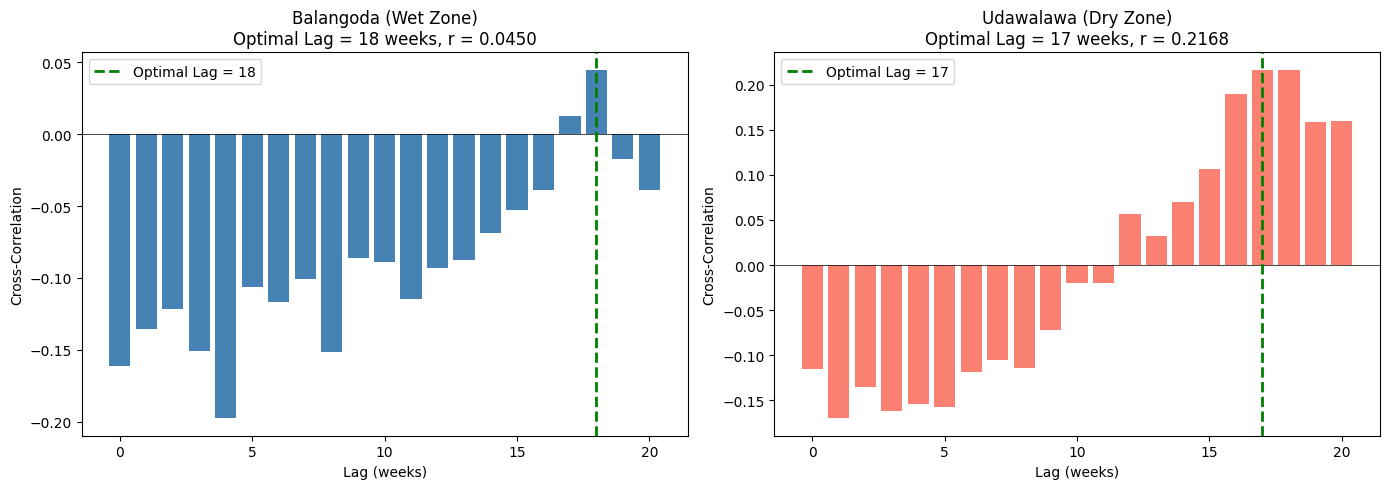

✓ Saved: 21_cross_correlation_comparison.png


In [ ]:
# SECTION 5: CROSS-CORRELATION COMPARISON PLOT

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Balangoda
axes[0].bar(range(len(ccf_values_bal)), ccf_values_bal, color='steelblue')
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[0].axvline(x=optimal_lag_bal, color='green', linestyle='--', linewidth=2, label=f'Optimal Lag = {optimal_lag_bal}')
axes[0].set_xlabel('Lag (weeks)')
axes[0].set_ylabel('Cross-Correlation')
axes[0].set_title(f'Balangoda (Wet Zone)\nOptimal Lag = {optimal_lag_bal} weeks, r = {max_corr_bal:.4f}')
axes[0].legend()

# Udawalawa
axes[1].bar(range(len(ccf_values_uda)), ccf_values_uda, color='salmon')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].axvline(x=optimal_lag_uda, color='green', linestyle='--', linewidth=2, label=f'Optimal Lag = {optimal_lag_uda}')
axes[1].set_xlabel('Lag (weeks)')
axes[1].set_ylabel('Cross-Correlation')
axes[1].set_title(f'Udawalawa (Dry Zone)\nOptimal Lag = {optimal_lag_uda} weeks, r = {max_corr_uda:.4f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('21_cross_correlation_comparison.png', dpi=150)
plt.show()
print("✓ Saved: 21_cross_correlation_comparison.png")

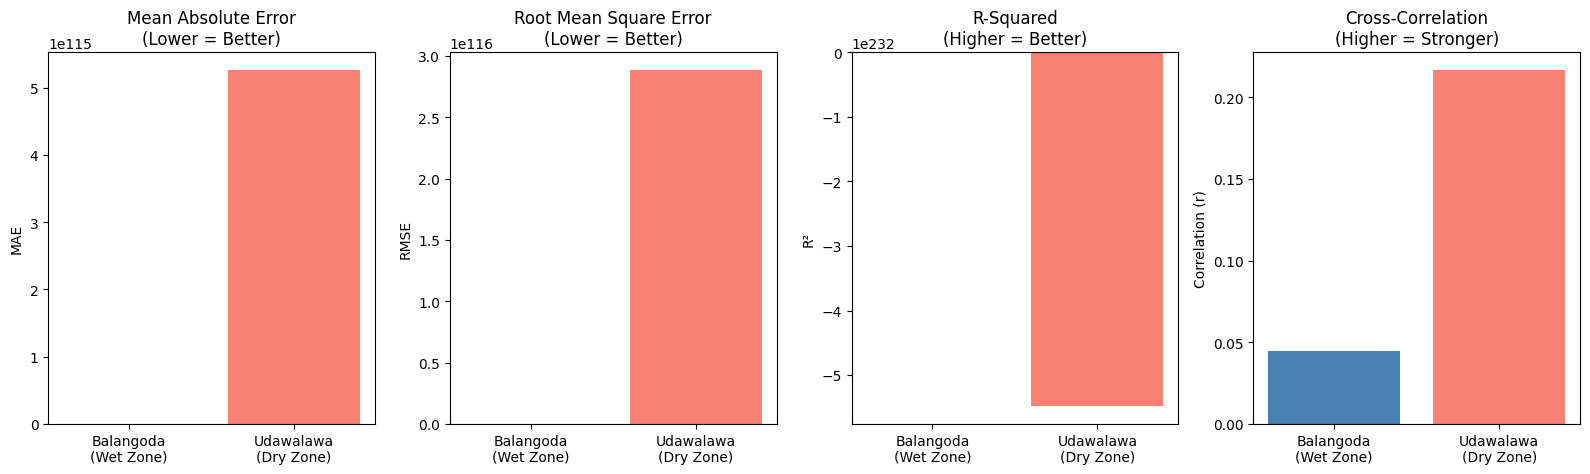

✓ Saved: 22_metrics_comparison.png


In [ ]:
# SECTION 6: MODEL METRICS COMPARISON PLOT

fig, axes = plt.subplots(1, 4, figsize=(16, 5))

# MAE
axes[0].bar(['Balangoda\n(Wet Zone)', 'Udawalawa\n(Dry Zone)'], [bal_mae, uda_mae],
            color=['steelblue', 'salmon'])
axes[0].set_ylabel('MAE')
axes[0].set_title('Mean Absolute Error\n(Lower = Better)')

# RMSE
axes[1].bar(['Balangoda\n(Wet Zone)', 'Udawalawa\n(Dry Zone)'], [bal_rmse, uda_rmse],
            color=['steelblue', 'salmon'])
axes[1].set_ylabel('RMSE')
axes[1].set_title('Root Mean Square Error\n(Lower = Better)')

# R²
axes[2].bar(['Balangoda\n(Wet Zone)', 'Udawalawa\n(Dry Zone)'], [bal_r2, uda_r2],
            color=['steelblue', 'salmon'])
axes[2].set_ylabel('R²')
axes[2].set_title('R-Squared\n(Higher = Better)')

# Cross-correlation
axes[3].bar(['Balangoda\n(Wet Zone)', 'Udawalawa\n(Dry Zone)'], [max_corr_bal, max_corr_uda],
            color=['steelblue', 'salmon'])
axes[3].set_ylabel('Correlation (r)')
axes[3].set_title('Cross-Correlation\n(Higher = Stronger)')

plt.tight_layout()
plt.savefig('22_metrics_comparison.png', dpi=150)
plt.show()
print("✓ Saved: 22_metrics_comparison.png")


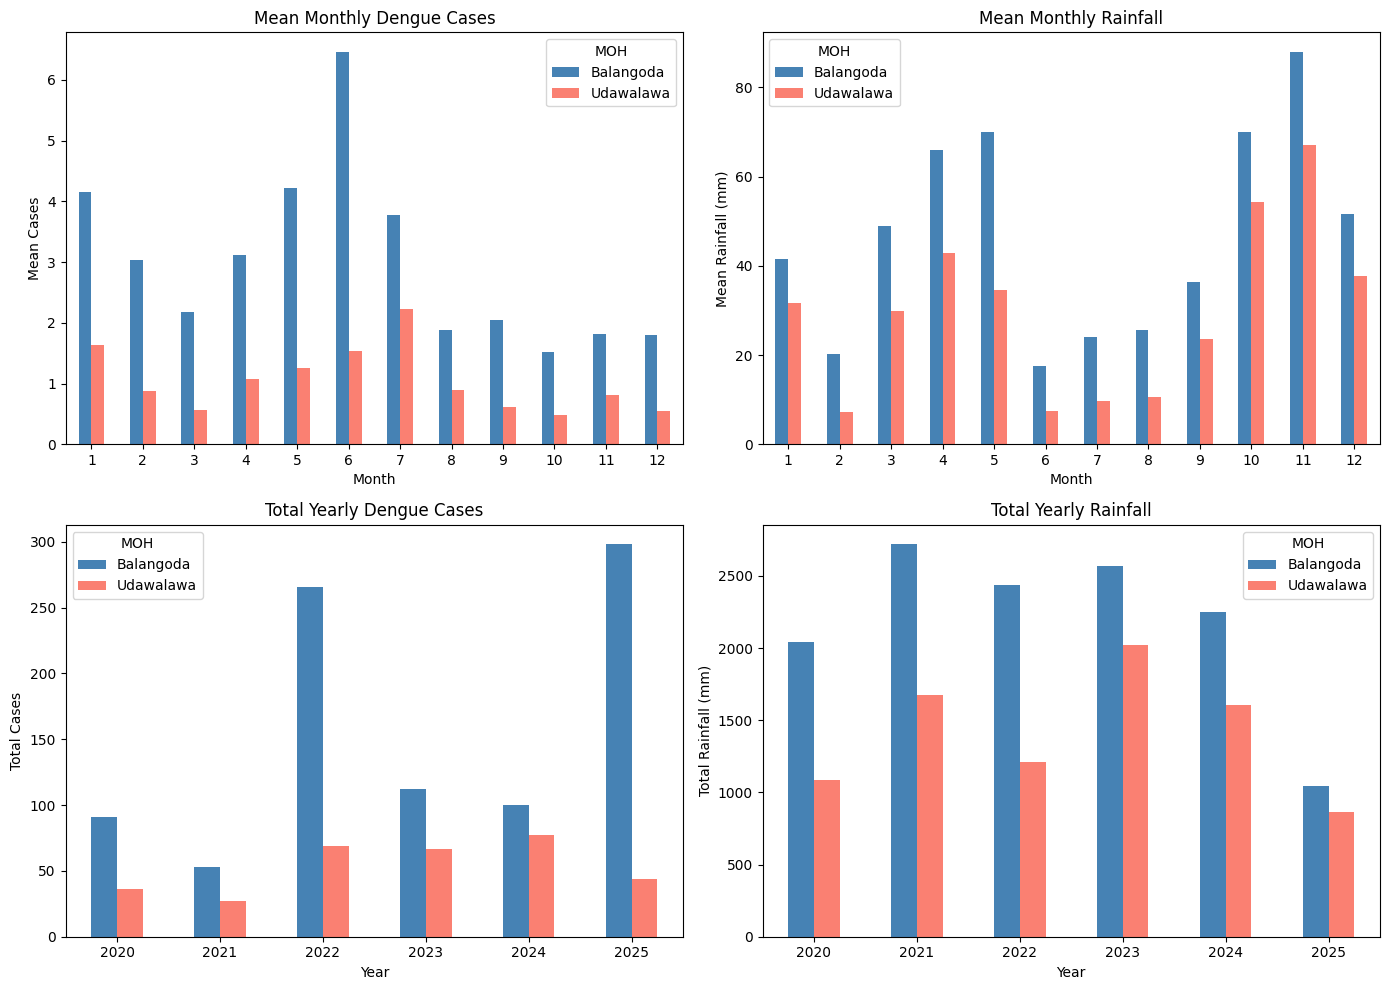

✓ Saved: 23_seasonal_comparison.png


In [ ]:
# SECTION 7: SEASONAL PATTERN COMPARISON

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Monthly dengue comparison
monthly_dengue = df.groupby(['Month', 'MOH'])['Dengue_Cases'].mean().unstack()
monthly_dengue.plot(kind='bar', ax=axes[0, 0], color=['steelblue', 'salmon'])
axes[0, 0].set_title('Mean Monthly Dengue Cases')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Mean Cases')
axes[0, 0].legend(title='MOH')
axes[0, 0].tick_params(axis='x', rotation=0)

# Monthly rainfall comparison
monthly_rain = df.groupby(['Month', 'MOH'])['Rainfall_mm'].mean().unstack()
monthly_rain.plot(kind='bar', ax=axes[0, 1], color=['steelblue', 'salmon'])
axes[0, 1].set_title('Mean Monthly Rainfall')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Mean Rainfall (mm)')
axes[0, 1].legend(title='MOH')
axes[0, 1].tick_params(axis='x', rotation=0)

# Yearly dengue comparison
yearly_dengue = df.groupby(['Year', 'MOH'])['Dengue_Cases'].sum().unstack()
yearly_dengue.plot(kind='bar', ax=axes[1, 0], color=['steelblue', 'salmon'])
axes[1, 0].set_title('Total Yearly Dengue Cases')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Total Cases')
axes[1, 0].legend(title='MOH')
axes[1, 0].tick_params(axis='x', rotation=0)

# Yearly rainfall comparison
yearly_rain = df.groupby(['Year', 'MOH'])['Rainfall_mm'].sum().unstack()
yearly_rain.plot(kind='bar', ax=axes[1, 1], color=['steelblue', 'salmon'])
axes[1, 1].set_title('Total Yearly Rainfall')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Total Rainfall (mm)')
axes[1, 1].legend(title='MOH')
axes[1, 1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('23_seasonal_comparison.png', dpi=150)
plt.show()
print("✓ Saved: 23_seasonal_comparison.png")


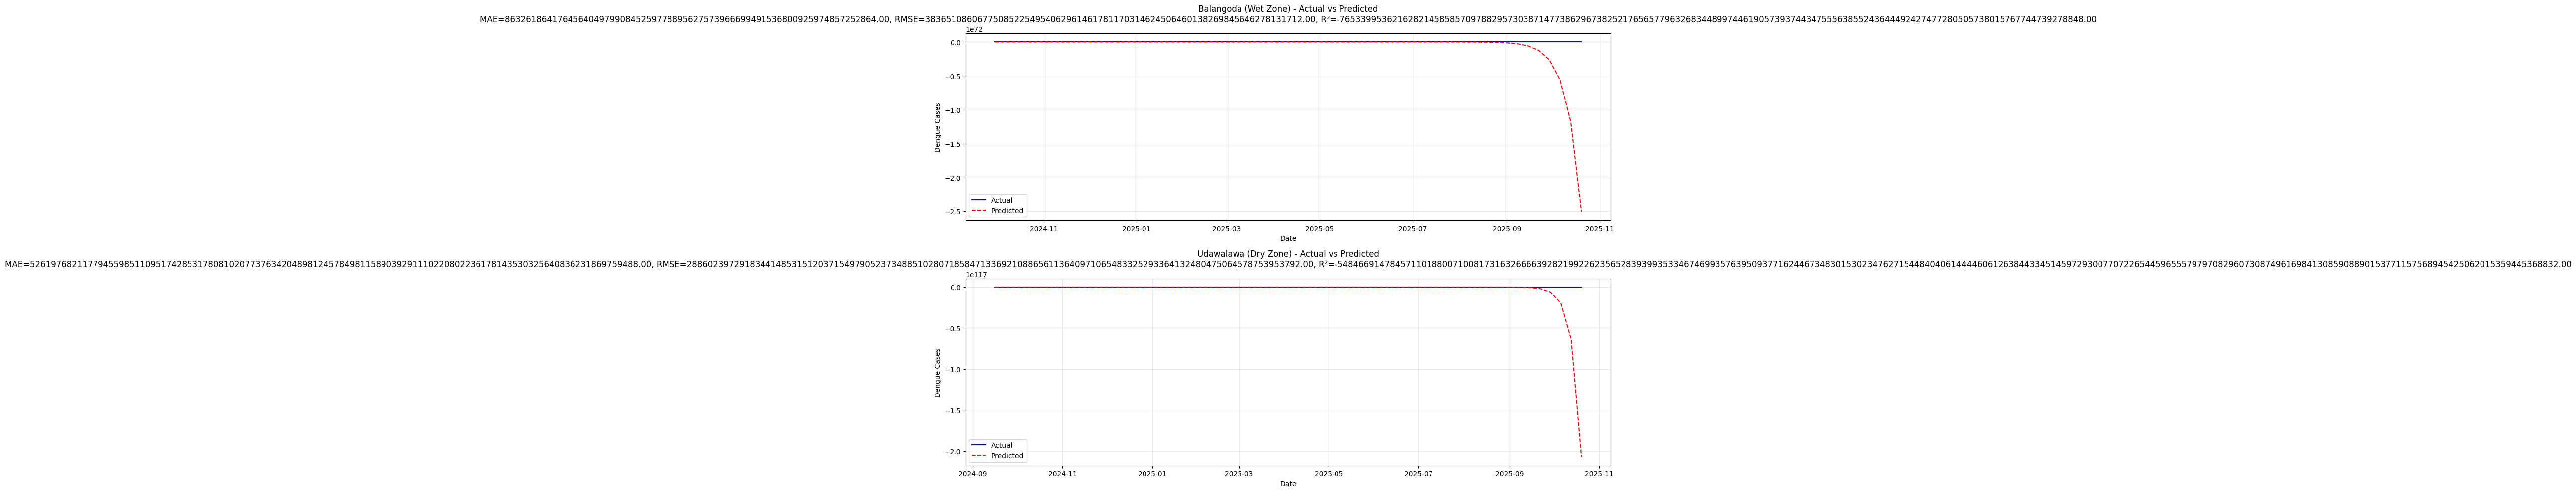

✓ Saved: 24_prediction_comparison.png


In [ ]:
# SECTION 8: PREDICTION COMPARISON PLOT

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Balangoda predictions
axes[0].plot(bal_test['Week_Start'].values, bal_test['Dengue_Cases'].values, 'b-', label='Actual', linewidth=1.5)
axes[0].plot(bal_test['Week_Start'].values, bal_pred_mean.values, 'r--', label='Predicted', linewidth=1.5)
axes[0].fill_between(bal_test['Week_Start'].values,
                     bal_pred_ci.iloc[:, 0].values,
                     bal_pred_ci.iloc[:, 1].values,
                     color='red', alpha=0.2)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Dengue Cases')
axes[0].set_title(f'Balangoda (Wet Zone) - Actual vs Predicted\nMAE={bal_mae:.2f}, RMSE={bal_rmse:.2f}, R²={bal_r2:.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Udawalawa predictions
axes[1].plot(uda_test['Week_Start'].values, uda_test['Dengue_Cases'].values, 'b-', label='Actual', linewidth=1.5)
axes[1].plot(uda_test['Week_Start'].values, uda_pred_mean.values, 'r--', label='Predicted', linewidth=1.5)
axes[1].fill_between(uda_test['Week_Start'].values,
                     uda_pred_ci.iloc[:, 0].values,
                     uda_pred_ci.iloc[:, 1].values,
                     color='red', alpha=0.2)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Dengue Cases')
axes[1].set_title(f'Udawalawa (Dry Zone) - Actual vs Predicted\nMAE={uda_mae:.2f}, RMSE={uda_rmse:.2f}, R²={uda_r2:.2f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('24_prediction_comparison.png', dpi=150)
plt.show()
print("✓ Saved: 24_prediction_comparison.png")

In [ ]:
# SECTION 9: SAVE FINAL RESULTS TO CSV

# Save comparison tables
comparison_stats.to_csv('final_descriptive_comparison.csv', index=False)
relationship_comparison.to_csv('final_relationship_comparison.csv', index=False)
model_comparison.to_csv('final_model_comparison.csv', index=False)

print("✓ Saved: final_descriptive_comparison.csv")
print("✓ Saved: final_relationship_comparison.csv")
print("✓ Saved: final_model_comparison.csv")

# Save predictions
bal_test_results = bal_test[['Week_Start', 'Dengue_Cases']].copy()
bal_test_results['Predicted'] = bal_pred_mean.values
bal_test_results['MOH'] = 'Balangoda'

uda_test_results = uda_test[['Week_Start', 'Dengue_Cases']].copy()
uda_test_results['Predicted'] = uda_pred_mean.values
uda_test_results['MOH'] = 'Udawalawa'

all_predictions = pd.concat([bal_test_results, uda_test_results])
all_predictions.to_csv('final_predictions.csv', index=False)
print("✓ Saved: final_predictions.csv")

✓ Saved: final_descriptive_comparison.csv
✓ Saved: final_relationship_comparison.csv
✓ Saved: final_model_comparison.csv
✓ Saved: final_predictions.csv
